In [1]:
import torch
from PIL import Image, ImageDraw, ImageFont
import os
import sys
import glob
import numpy as np
import cv2

# --- 로컬 Pororo 모듈 경로 설정 ---
# 이 노트북 파일(predict.ipynb)은 customOCR 폴더에 있으므로,
# pororo_main 폴더는 같은 레벨에 있다고 가정합니다.
PORORO_PATH = os.path.abspath(os.path.join(os.path.dirname('.'), '..', 'pororo_easyocr_main'))
if PORORO_PATH not in sys.path:
    sys.path.append(PORORO_PATH)
    print(f"Added to sys.path: {PORORO_PATH}")

try:
    from main import EasyPororoOcr
except ImportError:
    print(f"오류: '{PORORO_PATH}' 경로에서 Pororo 모듈을 찾을 수 없습니다.")
    print("customOCR 폴더와 같은 위치에 'pororo_main' 폴더가 있는지 확인해주세요.")
    # In a notebook, we might not want to exit, just raise the error.
    raise

from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
# config.py 파일이 src 폴더 안에 있으므로 경로를 추가해줍니다.
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('.'), 'src')))
from config import OUTPUT_DIR, id2label, DEVICE

print("\n필요한 모듈을 모두 로드했습니다.")

Added to sys.path: c:\code\pororo_easyocr_main



필요한 모듈을 모두 로드했습니다.


In [2]:
import re
import torch.nn.functional as F

class DocumentPredictor:
    """
    학습된 LayoutLMv3 모델을 사용하여 문서 이미지에서 정보를 추출하는 클래스.
    (지능적인 전/후처리 기능 강화 v5 - 키워드와 숫자 패턴 동시 고려)
    """
    def __init__(self, model_path, confidence_threshold=0.85):
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"모델 경로를 찾을 수 없습니다: {model_path}. train.py를 먼저 실행하여 모델을 학습시키세요.")
        
        print("모델과 프로세서를 로딩합니다...")
        self.processor = LayoutLMv3Processor.from_pretrained(model_path)
        self.model = LayoutLMv3ForTokenClassification.from_pretrained(model_path)
        self.model.to(DEVICE)
        self.model.eval()
        
        print("OCR 엔진(Local Pororo)을 초기화합니다...")
        use_gpu = torch.cuda.is_available()
        print(f"Use_gpu : {use_gpu}")
        self.ocr_reader = EasyPororoOcr(gpu=use_gpu)
        self.confidence_threshold = confidence_threshold
        print(f"설정된 신뢰도 임계값: {self.confidence_threshold}")

    def _preprocess_image(self, image, top_crop_ratio=0.12, bottom_crop_ratio=0.08):
        """이미지의 상단/하단을 잘라내어 불필요한 UI 요소를 제거합니다."""
        width, height = image.size
        top_crop = int(height * top_crop_ratio)
        bottom_crop = int(height * (1 - bottom_crop_ratio))
        
        cropped_image = image.crop((0, top_crop, width, bottom_crop))
        return cropped_image, top_crop

    def _split_boxes_aggressively(self, ocr_words, ocr_boxes):
        """OCR 결과를 공백 기준으로 분할하되, 특정 패턴은 예외 처리합니다."""
        new_words, new_boxes = [], []
        exception_pattern = re.compile(r'(\d{1,2}월\s\d{1,2}일|\d{1,4}\.\d{1,2}\.\d{1,2}|\d{1,2}:\d{1,2})')
        for word, box in zip(ocr_words, ocr_boxes):
            if exception_pattern.fullmatch(word):
                new_words.append(word)
                new_boxes.append(box)
                continue
            parts = word.split()
            if len(parts) > 1:
                new_words.extend(parts)
                new_boxes.extend([box] * len(parts))
            else:
                new_words.append(word)
                new_boxes.append(box)
        return new_words, new_boxes

    def predict(self, image_path):
        """단일 이미지에 대해 OCR 및 정보 추출을 수행합니다."""
        print(f"\n'{os.path.basename(image_path)}'에서 텍스트를 추출합니다...")
        original_image = Image.open(image_path).convert("RGB")
        
        cropped_image, y_offset = self._preprocess_image(original_image.copy())
        
        # ★★★ 변경점: .copy()를 추가하여 메모리 레이아웃 문제 해결 ★★★
        # 1. PIL 이미지를 numpy 배열로 변환합니다.
        cropped_image_np = np.array(cropped_image)
        
        # 2. PIL의 RGB 순서를 OpenCV의 BGR 순서로 변경합니다.
        cropped_image_np = cv2.cvtColor(cropped_image_np, cv2.COLOR_RGB2BGR)
        
        # 3. (가장 중요) .copy()를 호출하여 메모리상에 완전히 새로운 연속 배열을 만듭니다.
        #    이것이 Windows + OpenCV 환경의 미묘한 메모리 문제를 해결합니다.
        cropped_image_np = cropped_image_np.copy()
        
        # 4. run_ocr에 파일 경로 대신 numpy 배열을 직접 전달합니다.
        self.ocr_reader.run_ocr(cropped_image_np, debug=False)
        ocr_results = self.ocr_reader.get_ocr_result()

        if not ocr_results:
            print("이미지에서 텍스트를 찾을 수 없습니다.")
            return [], original_image

        raw_words_initial = []
        raw_boxes_initial = []
        # ocr_results는 [box, text] 쌍의 리스트입니다.
        for box, text in ocr_results:
            raw_words_initial.append(text)
            
            # box 형식: [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
            # 이 좌표를 [xmin, ymin, xmax, ymax] 형식으로 변환합니다.
            x_coords = [p[0] for p in box]
            y_coords = [p[1] for p in box]
            raw_boxes_initial.append([
                min(x_coords), 
                min(y_coords) + y_offset, 
                max(x_coords), 
                max(y_coords) + y_offset
            ])

        words, raw_boxes = raw_words_initial, raw_boxes_initial

        width, height = original_image.size
        boxes = [[int(1000 * b[0] / width), int(1000 * b[1] / height), int(1000 * b[2] / width), int(1000 * b[3] / height)] for b in raw_boxes]

        encoding = self.processor(
            original_image, words, boxes=boxes, return_tensors="pt",
            padding="max_length", truncation=True,
        ).to(DEVICE)

        with torch.no_grad():
            outputs = self.model(**encoding)
        
        probabilities = F.softmax(outputs.logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1)
        max_probs = torch.max(probabilities, dim=-1).values
        
        results = self._postprocess(encoding, predictions.squeeze().tolist(), max_probs.squeeze().tolist(), words, raw_boxes)
        
        return results, original_image

    def _postprocess(self, encoding, predictions, probabilities, words, raw_boxes):
        """
        예측 결과를 병합하고, 텍스트 내용과 숫자 패턴을 함께 고려하여 라벨을 재분류하는 후처리 함수.
        (규칙 우선순위 조정)
        """
        word_ids = encoding.word_ids(0)
        
        # 1. 신뢰도 기반 초기 필터링
        initial_preds = []
        previous_word_idx = None
        for idx, (pred_id, prob) in enumerate(zip(predictions, probabilities)):
            word_idx = word_ids[idx]
            if word_idx is None or word_idx == previous_word_idx:
                continue
            
            label = id2label[pred_id]
            if prob >= self.confidence_threshold:
                initial_preds.append({
                    "text": words[word_idx], "label": label, "box": raw_boxes[word_idx],
                    "confidence": prob, "word_idx": word_idx
                })
            previous_word_idx = word_idx

        if not initial_preds:
            return []

        # 2. 연속된 같은 라벨 병합
        merged_preds = []
        if initial_preds:
            current_pred = initial_preds[0]
            for i in range(1, len(initial_preds)):
                next_pred = initial_preds[i]
                if next_pred['label'] == current_pred['label'] and next_pred['word_idx'] == current_pred['word_idx'] + 1:
                    current_pred['text'] += " " + next_pred['text']
                    current_pred['box'][2] = next_pred['box'][2]
                    current_pred['box'][3] = max(current_pred['box'][3], next_pred['box'][3])
                    current_pred['confidence'] = max(current_pred['confidence'], next_pred['confidence'])
                    current_pred['word_idx'] = next_pred['word_idx']
                else:
                    merged_preds.append(current_pred)
                    current_pred = next_pred
            merged_preds.append(current_pred)

        # 3. ★★★ 키워드와 숫자 패턴을 함께 고려한 최종 재분류 (우선순위 조정) ★★★
        final_preds = []
        for pred in merged_preds:
            text = pred['text']
            has_digits = any(char.isdigit() for char in text)

            if has_digits:
                # 더 구체적인 '입금/출금'을 먼저 확인
                if '입금' in text or '+' in text:
                    pred['label'] = 'AMOUNT_IN'
                elif '출금' in text or '-' in text:
                    pred['label'] = 'AMOUNT_OUT'
                # 그 다음 '잔액'을 확인
                elif '잔액' in text:
                    pred['label'] = 'BALANCE'
            
            pred['confidence'] = f"{pred['confidence']:.2f}"
            final_preds.append(pred)
            
        return final_preds

print("DocumentPredictor 클래스가 '키워드+숫자패턴' 기반의 최종 후처리 기능으로 업데이트되었습니다.")

DocumentPredictor 클래스가 '키워드+숫자패턴' 기반의 최종 후처리 기능으로 업데이트되었습니다.


In [3]:
def draw_predictions(image, predictions, font_path=None):
    """예측 결과를 원본 이미지 위에 시각화합니다. (신뢰도 표시 및 색상 개선)"""
    draw = ImageDraw.Draw(image)
    
    try:
        font = ImageFont.truetype(font_path or "malgun.ttf", size=15)
    except IOError:
        print("경고: 'malgun.ttf' 폰트를 찾을 수 없습니다. 기본 폰트를 사용합니다.")
        font = ImageFont.load_default()

    # ★★★ 시인성 좋은 색상으로 변경 ★★★
    label_colors = {
        "DATE_HEADER": "#ff7f0e", # 주황
        "DATE": "#1f77b4",       # 파랑
        "TIME": "#d62728",       # 빨강
        "MERCHANT": "#2ca02c",   # 초록
        "MEMO": "#9467bd",       # 보라
        "AMOUNT_IN": "#8c564b",  # 갈색
        "AMOUNT_OUT": "#e377c2", # 핑크
        "BALANCE": "#7f7f7f",    # 회색
    }

    for pred in predictions:
        box = pred['box']
        label = pred['label']
        color = label_colors.get(label, "#bcbd22") # 기본값: 올리브색
        
        draw.rectangle(box, outline=color, width=3)
        
        # ★★★ 라벨 텍스트에 신뢰도 점수 추가 ★★★
        label_text = f"{label} ({pred['confidence']})"
        
        text_bbox = draw.textbbox((box[0], box[1]), label_text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        label_bg_box = [box[0], box[1] - text_height - 6, box[0] + text_width + 8, box[1]]
        draw.rectangle(label_bg_box, fill=color)
        
        draw.text((box[0] + 4, box[1] - text_height - 4), label_text, fill="white", font=font)
        
    return image

print("draw_predictions 함수가 신뢰도 표시 기능과 새로운 색상 구성으로 업데이트되었습니다.")

draw_predictions 함수가 신뢰도 표시 기능과 새로운 색상 구성으로 업데이트되었습니다.


모델과 프로세서를 로딩합니다...
OCR 엔진(Local Pororo)을 초기화합니다...
Use_gpu : True
설정된 신뢰도 임계값: 0.85

처리 시작: KakaoTalk_20250624_075429567.png

'KakaoTalk_20250624_075429567.png'에서 텍스트를 추출합니다...

--- [KakaoTalk_20250624_075429567.png] 정보 추출 결과 ---


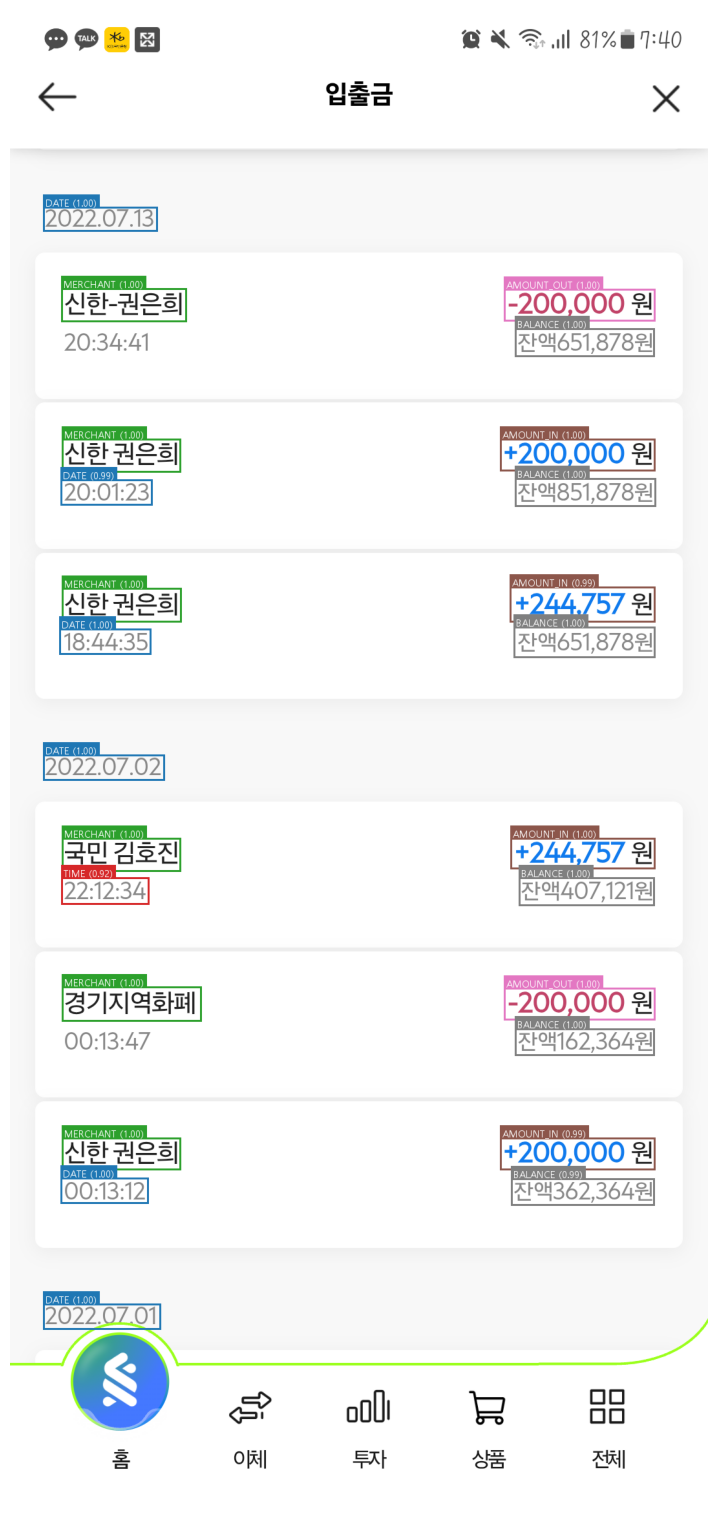


[텍스트 요약]
- DATE: 2022.07.13, 20:.01:23, 18.44:35, 2022.07.02, 00.13:12, 2022,07.01
- MERCHANT: 신한-권은희, 신한 권은희, 신한 권은희, 국민 김호진, 경기지역화폐, 신한 권은희
- AMOUNT_OUT: -200,000 원, -200,000 원
- BALANCE: 잔액651,878원, 잔액851,878원, 잔액651,878원, 잔액407,121원, 잔액162,364원, 잔액362,364원
- AMOUNT_IN: +200,000 원, +244,757 원, +244,757 원, +200,000 원
- TIME: 22:12:34
--------------------------------------------------

처리 시작: sanup1.jpg

'sanup1.jpg'에서 텍스트를 추출합니다...

--- [sanup1.jpg] 정보 추출 결과 ---


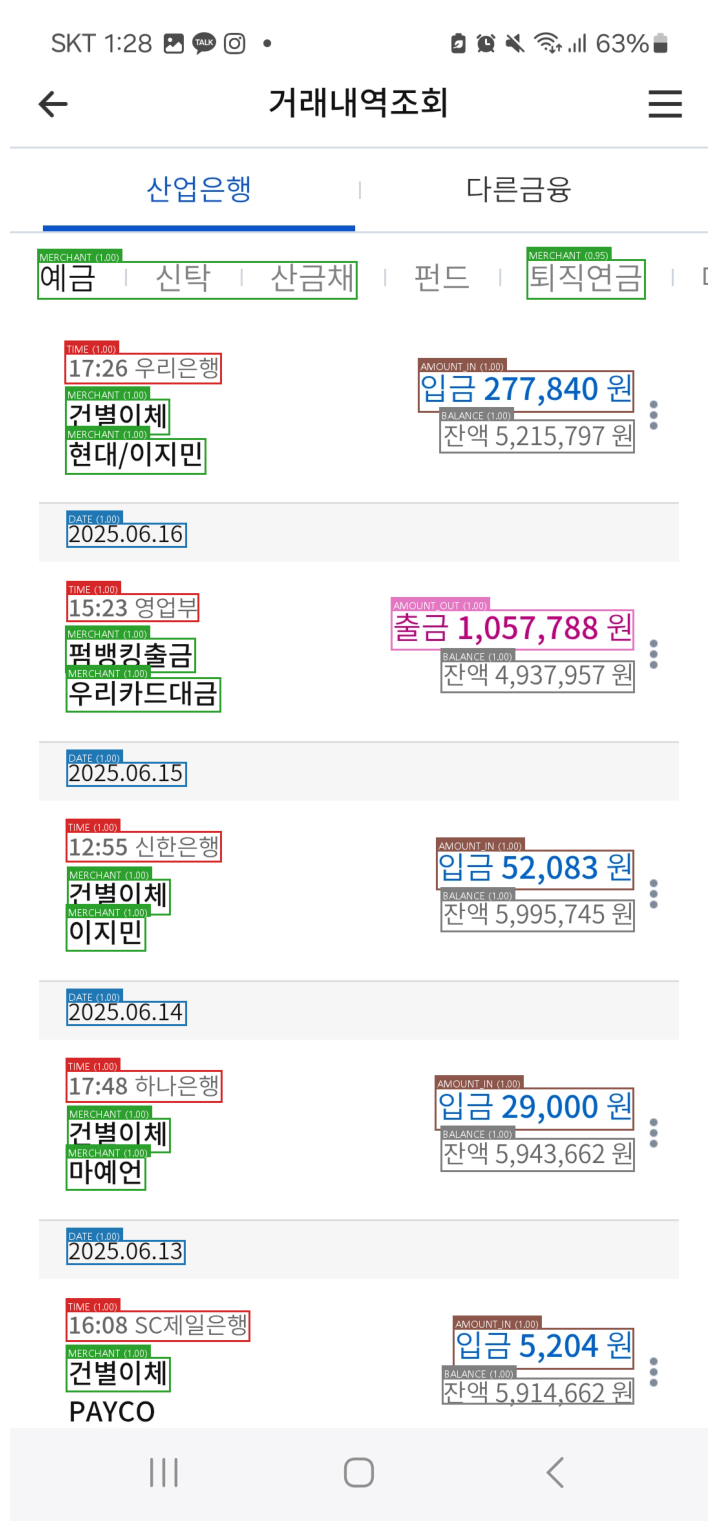


[텍스트 요약]
- MERCHANT: 예금 신탁 산금채, 퇴직연금, 건별이체, 현대)이지민, 펌뱅킹출금, 우리카드대금, 건별이체, 이지민, 건별이체, 마예언, 건별이체
- TIME: 17:26 우리은행, 15:23 영업부, 12:55 신한은행, 17:48 하나은행, 16:08 SC제일은행
- AMOUNT_IN: 입금 277,840 원, 입금 52,083 원, 입금 29,000 원, 입금 5,204 원
- BALANCE: 잔액 5,215,797 원, 잔액 4,937,957 원, 잔액 5,995,745 원, 잔액 5,943,662 원, 자액 5.914.66) 워
- DATE: 2025.06.16, 2025.06.15, 2025.06.14, 2025.06.13
- AMOUNT_OUT: 출금 1,057,788 원
--------------------------------------------------

처리 시작: sanup2.jpg

'sanup2.jpg'에서 텍스트를 추출합니다...

--- [sanup2.jpg] 정보 추출 결과 ---


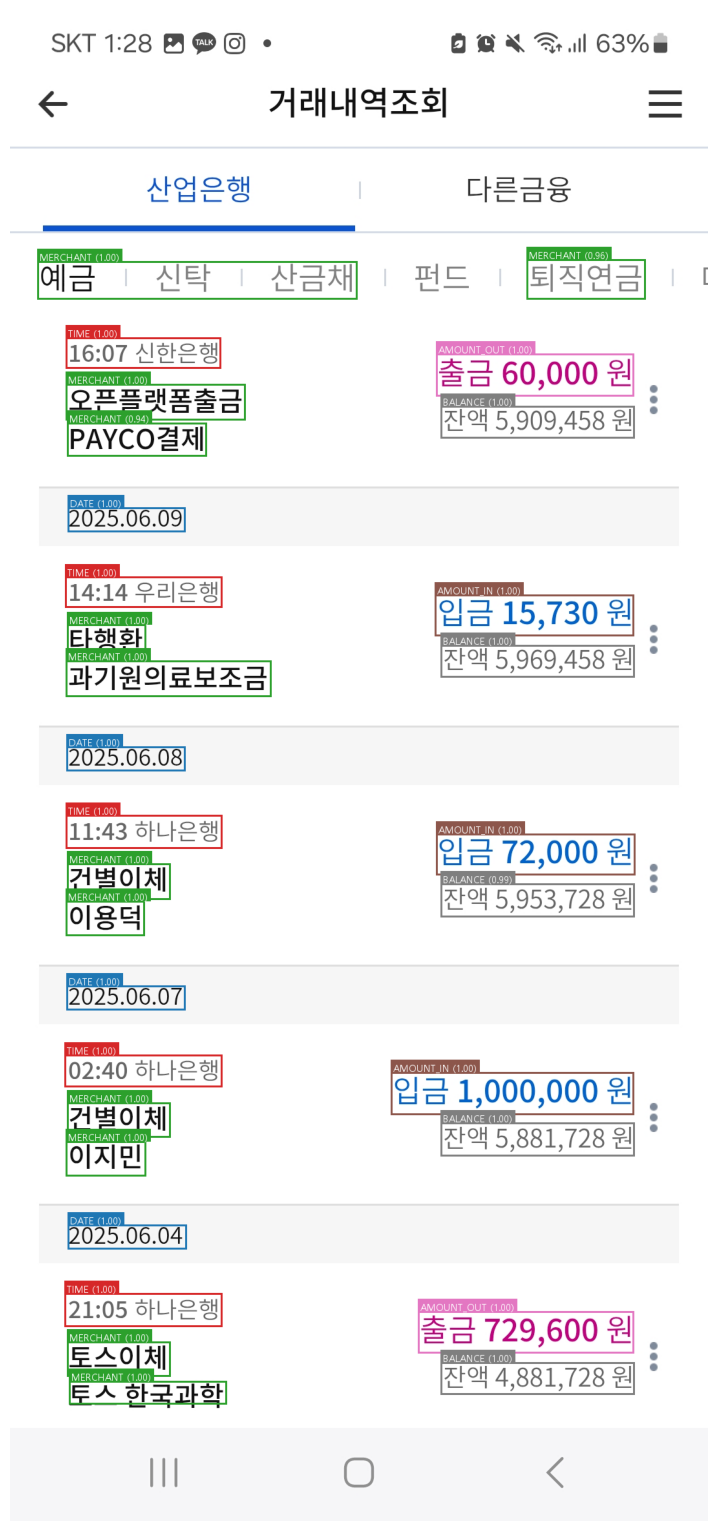


[텍스트 요약]
- MERCHANT: 예금 신탁 산금채, 퇴직연금, 오픈플랫폼출금, PAYCO결제, 타행환, 과기원의료보조금, 건별이체, 이용덕, 건별이체, 이지민, 토스이체, Eㅅ 하구가하
- TIME: 16:07 신한은행, 14:14 우리은행, 11:43 하나은행, 02:40 하나은행, 21:05 하나은행
- AMOUNT_OUT: 출금 60,000 원, 출금 729,600 원
- BALANCE: 잔액 5,909,458 원, 잔액 5,969,458 원, 잔액 5,953,728 원, 잔액 5,881,728 원, 잔액 4,881,728 원
- DATE: 2025.06.09, 2025.06.08, 2025.06.07, 2025.06.04
- AMOUNT_IN: 입금 15,730 원, 입금 72,000 원, 입금 1,000,000 원
--------------------------------------------------

처리 시작: sanup3.jpg

'sanup3.jpg'에서 텍스트를 추출합니다...

--- [sanup3.jpg] 정보 추출 결과 ---


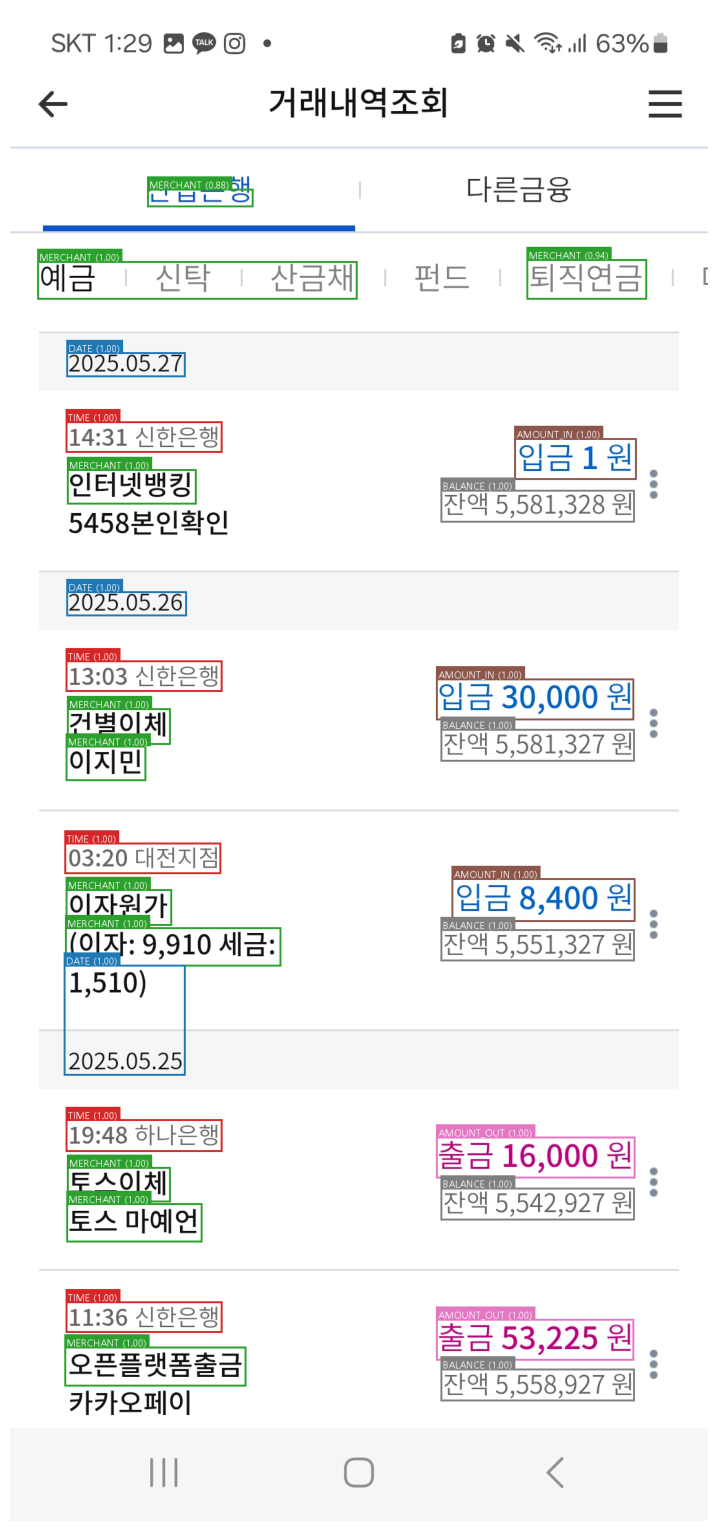


[텍스트 요약]
- MERCHANT: LdLO, 예금 신탁 산금채, 퇴직연금, 인터넷뱅킹, 건별이체, 이지민, 이자원가, (이자: 9,910 세금:, 토스이체, 토스 마예언, 오픈플랫폼출금
- DATE: 2025.05.27, 2025.05.26, 1,510) 2025.05.25
- TIME: 14:31 신한은행, 13:03 신한은행, 03:20 대전지점, 19:48 하나은행, 11:36 신한은행
- AMOUNT_IN: 입금 1 원, 입금 30,000 원, 입금 8,400 원
- BALANCE: 잔액 5,581,328 원, 잔액 5,581,327 원, 잔액 5,551,327 원, 잔액 5,542,927 원, 잔액 5,558,927 원
- AMOUNT_OUT: 출금 16,000 원, 출금 53,225 원
--------------------------------------------------

처리 시작: sanup4.jpg

'sanup4.jpg'에서 텍스트를 추출합니다...

--- [sanup4.jpg] 정보 추출 결과 ---


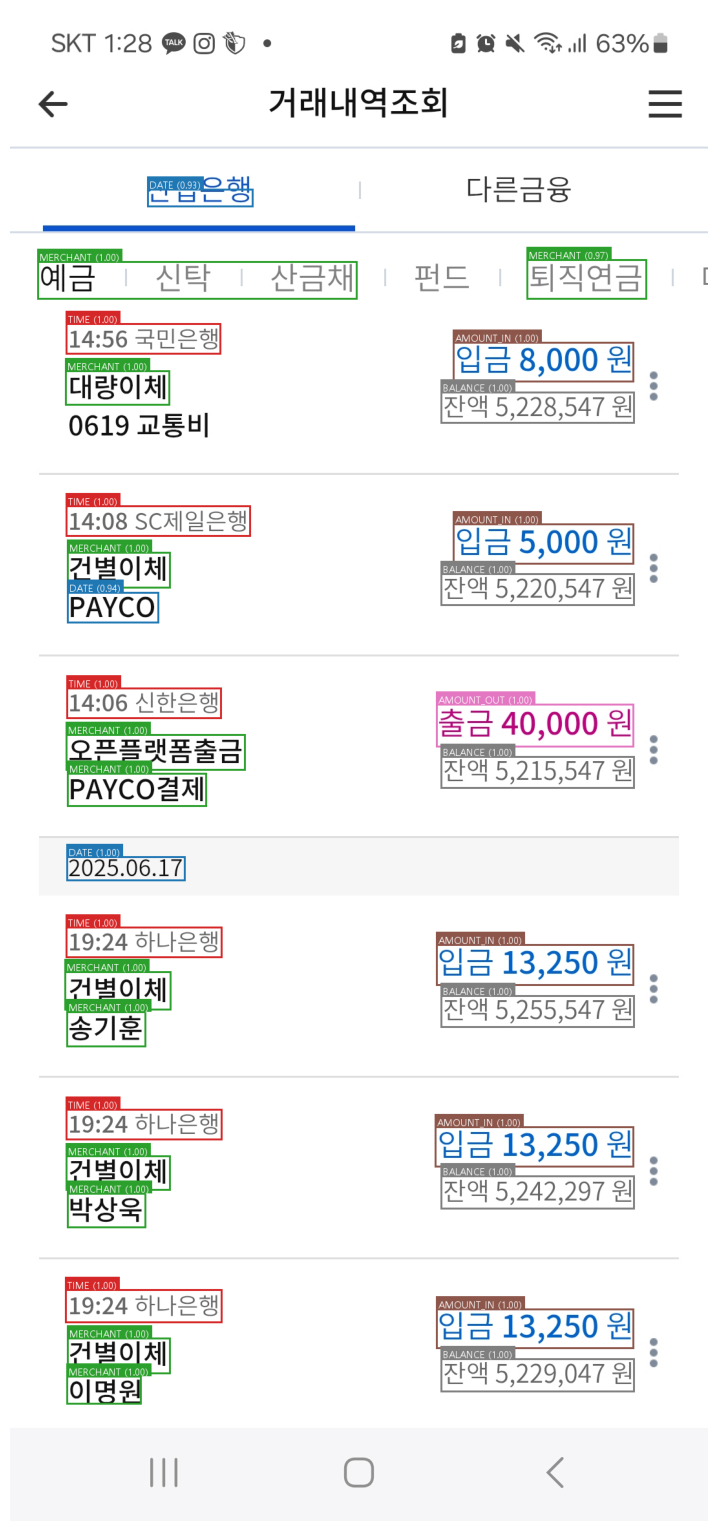


[텍스트 요약]
- DATE: LdLO, PAYCO, 2025.06.17
- MERCHANT: 예금 신탁 산금채, 퇴직연금, 대량이체, 건별이체, 오픈플랫폼출금, PAYCO결제, 건별이체, 송기훈, 건별이체, 박상욱, 건별이체, 이명위
- TIME: 14:56 국민은행, 14:08 SC제일은행, 14:06 신한은행, 19:24 하나은행, 19:24 하나은행, 19:24 하나은행
- AMOUNT_IN: 입금 8,000 원, 입금 5,000 원, 입금 13,250 원, 입금 13,250 원, 입금 13,250 원
- BALANCE: 잔액 5,228,547 원, 잔액 5,220,547 원, 잔액 5,215,547 원, 잔액 5,255,547 원, 잔액 5,242,297 원, 잔액 5,229,047 원
- AMOUNT_OUT: 출금 40,000 원
--------------------------------------------------

처리 시작: kookmin1.png

'kookmin1.png'에서 텍스트를 추출합니다...

--- [kookmin1.png] 정보 추출 결과 ---


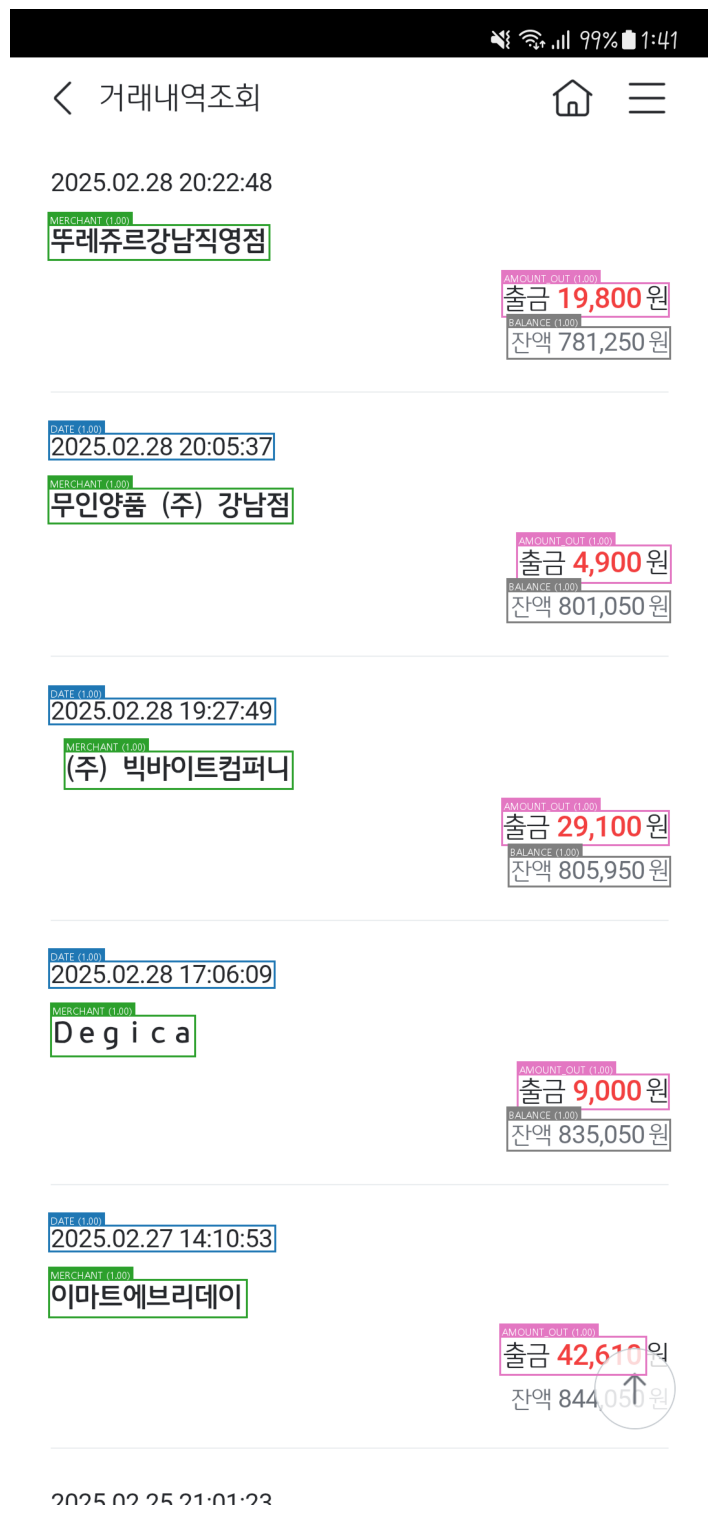


[텍스트 요약]
- MERCHANT: 뚜레쥬르강남직영점, 무인양품 (주) 강남점, (주) 빅바이트컴퍼니, Degica, 이마트에브리데이
- AMOUNT_OUT: 출금 19,800원, 출금 4,900원, 출금 29,100 원, 출금 9,000원, 출금 42,610
- BALANCE: 잔액 781,250 원, 잔액 801,050 원, 잔액 805,950 원, 잔액 835,050 원
- DATE: 2025.02.28 20:05:37, 2025.02.28 19:27:49, 2025.02.28 17:06:09, 2025.02.27 14:10:53
--------------------------------------------------

처리 시작: kookmin2.png

'kookmin2.png'에서 텍스트를 추출합니다...

--- [kookmin2.png] 정보 추출 결과 ---


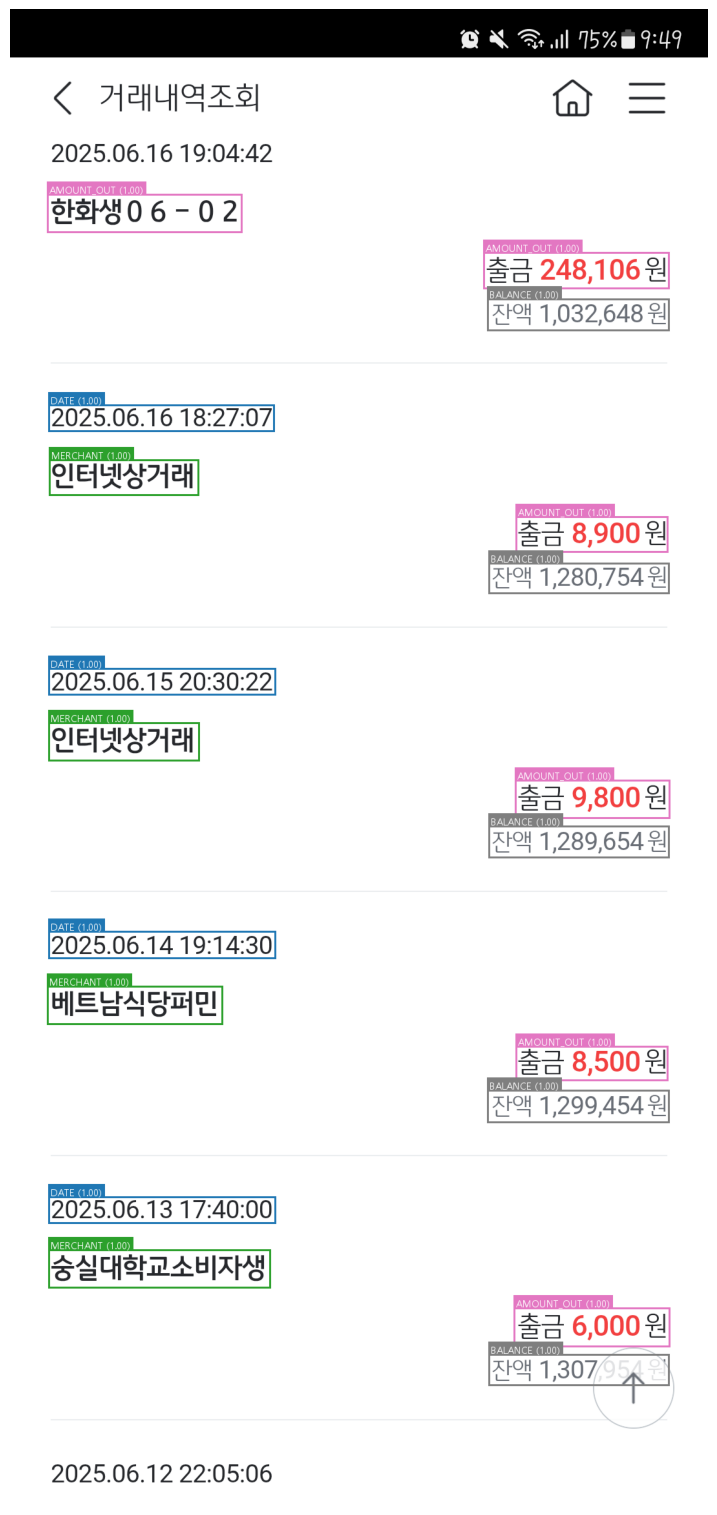


[텍스트 요약]
- AMOUNT_OUT: 한화생 0 6 - 0 2, 출금 248,106 원, 출금 8,900 원, 출금 9,800 원, 출금 8,500원, 출금 6,000 원
- BALANCE: 잔액 1,032,648 원, 잔액 1,280,754원, 잔액 1,289,654원, 잔액 1,299,454원, 잔액 1,3079 54원
- DATE: 2025.06.16 18:27:07, 2025.06.15 20:30:22, 2025.06.14 19:14:30, 2025.06.13 17:40:00
- MERCHANT: 인터넷상거래, 인터넷상거래, 베트남식당퍼민, 숭실대학교소비자생
--------------------------------------------------

처리 시작: kookmin3.png

'kookmin3.png'에서 텍스트를 추출합니다...

--- [kookmin3.png] 정보 추출 결과 ---


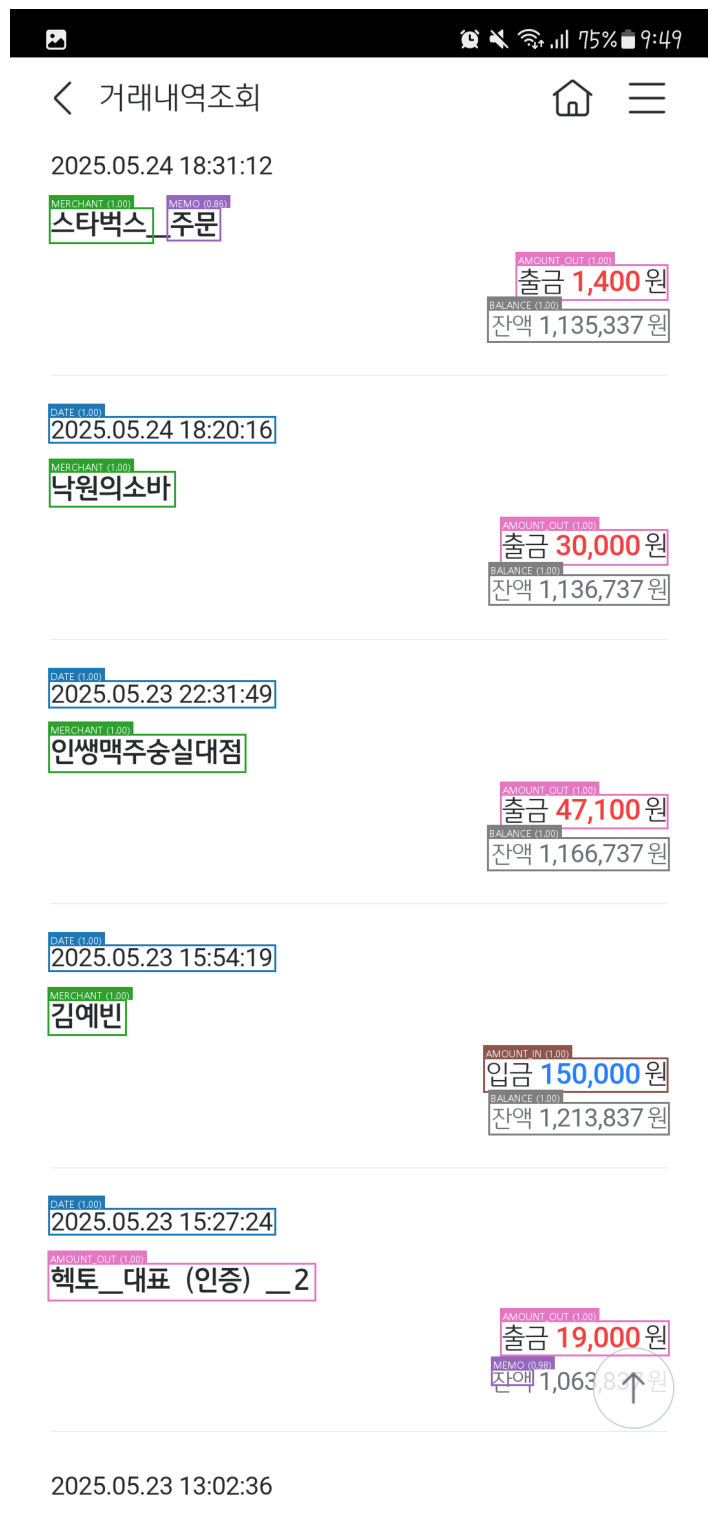


[텍스트 요약]
- MERCHANT: 스타벅스, 낙원의소바, 인쌩맥주숭실대점, 김예빈
- MEMO: 주문, 자애
- AMOUNT_OUT: 출금 1,400원, 출금 30,000 원, 출금 47,100 원, 헥토. 대표 (인증) -2, 출금 19,000원
- BALANCE: 잔액 1,135,337원, 잔액 1,136,737 원, 잔액 1,166,737 원, 잔액 1,213,837 원
- DATE: 2025.05.24 18:20:16, 2025.05.23 22:31:49, 2025.05.23 15:54:19, 2025.05.23 15:27:24
- AMOUNT_IN: 입금 150,000 원
--------------------------------------------------

처리 시작: kookmin4.png

'kookmin4.png'에서 텍스트를 추출합니다...

--- [kookmin4.png] 정보 추출 결과 ---


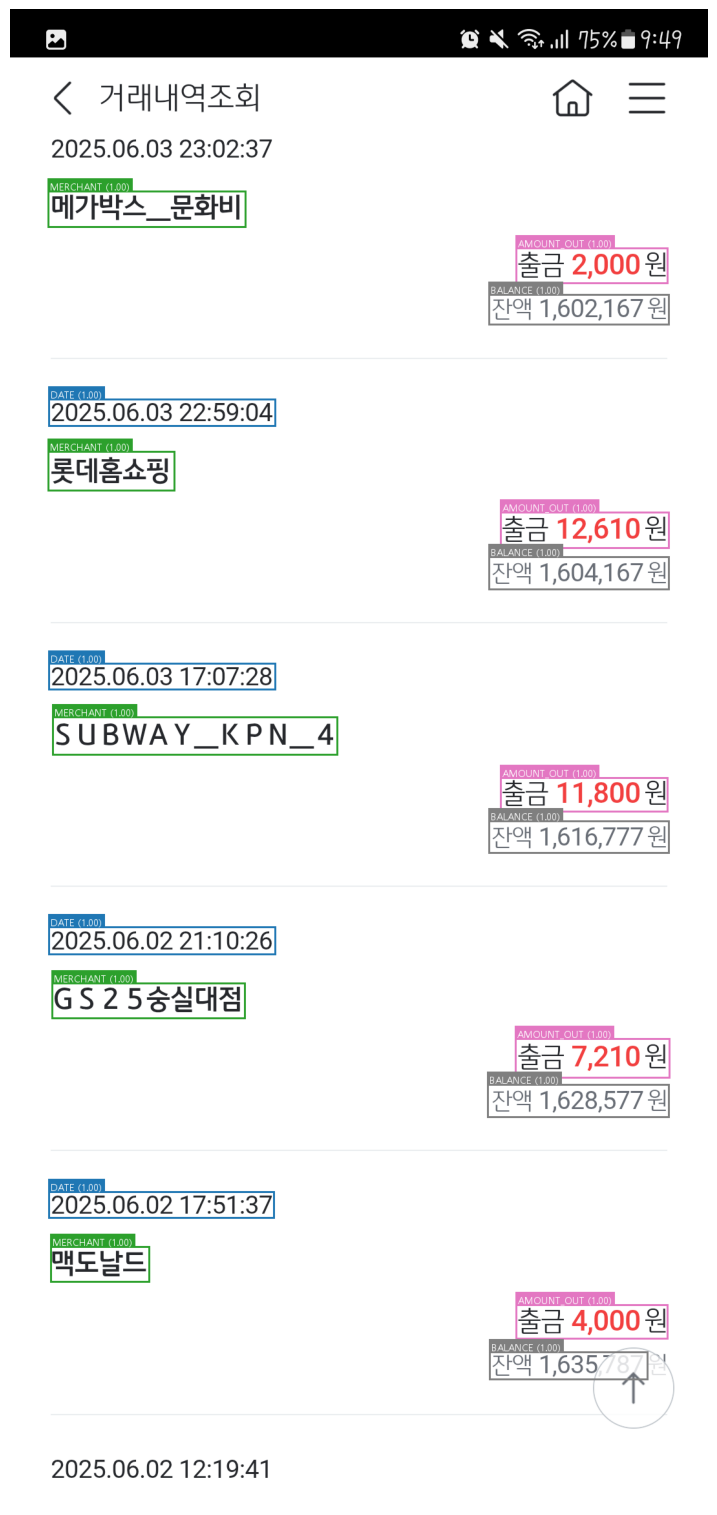


[텍스트 요약]
- MERCHANT: 메가박스. 문문화비, 롯데홈쇼핑, 4, G S 2 5숭실대점, 맥도날드
- AMOUNT_OUT: 출금 2,000 원, 출금 12,610원, 출금 11,800원, 출금 7,210원, 출금 4,000원
- BALANCE: 잔액 1,602,167원, 잔액 1,604,167 원, 잔액 1,616,777원, 잔액 1,628,577 원, 잔액 1,6357'87
- DATE: 2025.06.03 22:59:04, 2025.06.03 17:07:28, 2025.06.02 21:10:26, 2025.06.02 17:51:37
--------------------------------------------------

처리 시작: shinhan1.png

'shinhan1.png'에서 텍스트를 추출합니다...

--- [shinhan1.png] 정보 추출 결과 ---


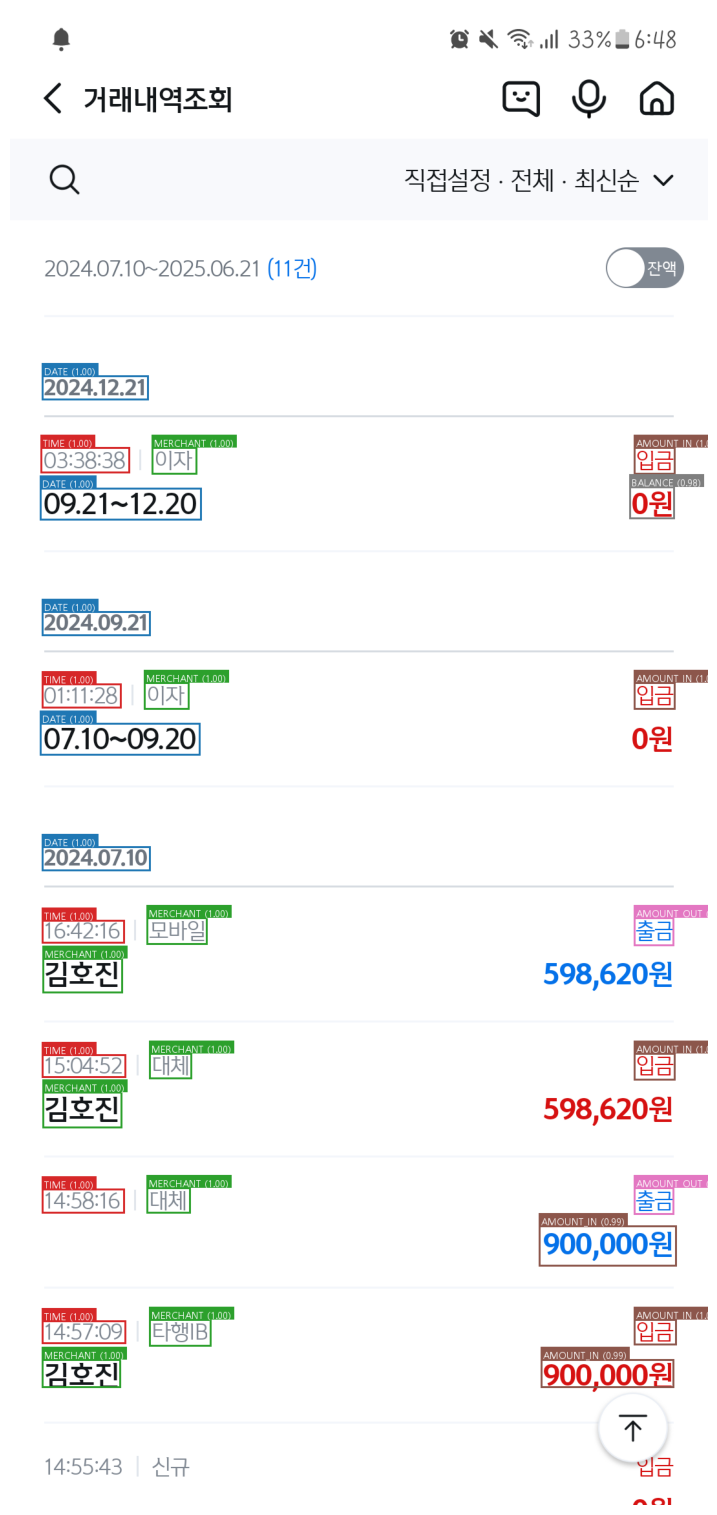


[텍스트 요약]
- DATE: 2024.12.21, 09.21~12.20, 2024.09.21, 07.10~09.20, 2024.07.10
- TIME: 03:38:38, 01:11:28, 16:42:16, 15:04:52, 14:58:16, 14:57:09
- MERCHANT: 이자, 이자, 모바일, 김호진, 대체, 김호진, 대체, 타행IB, 김호지
- AMOUNT_IN: 입금, 입금, 입금, 900,000원, 입금, 900,000원
- BALANCE: 0원
- AMOUNT_OUT: 출금, 출금
--------------------------------------------------

처리 시작: shinhyup.png

'shinhyup.png'에서 텍스트를 추출합니다...

--- [shinhyup.png] 정보 추출 결과 ---


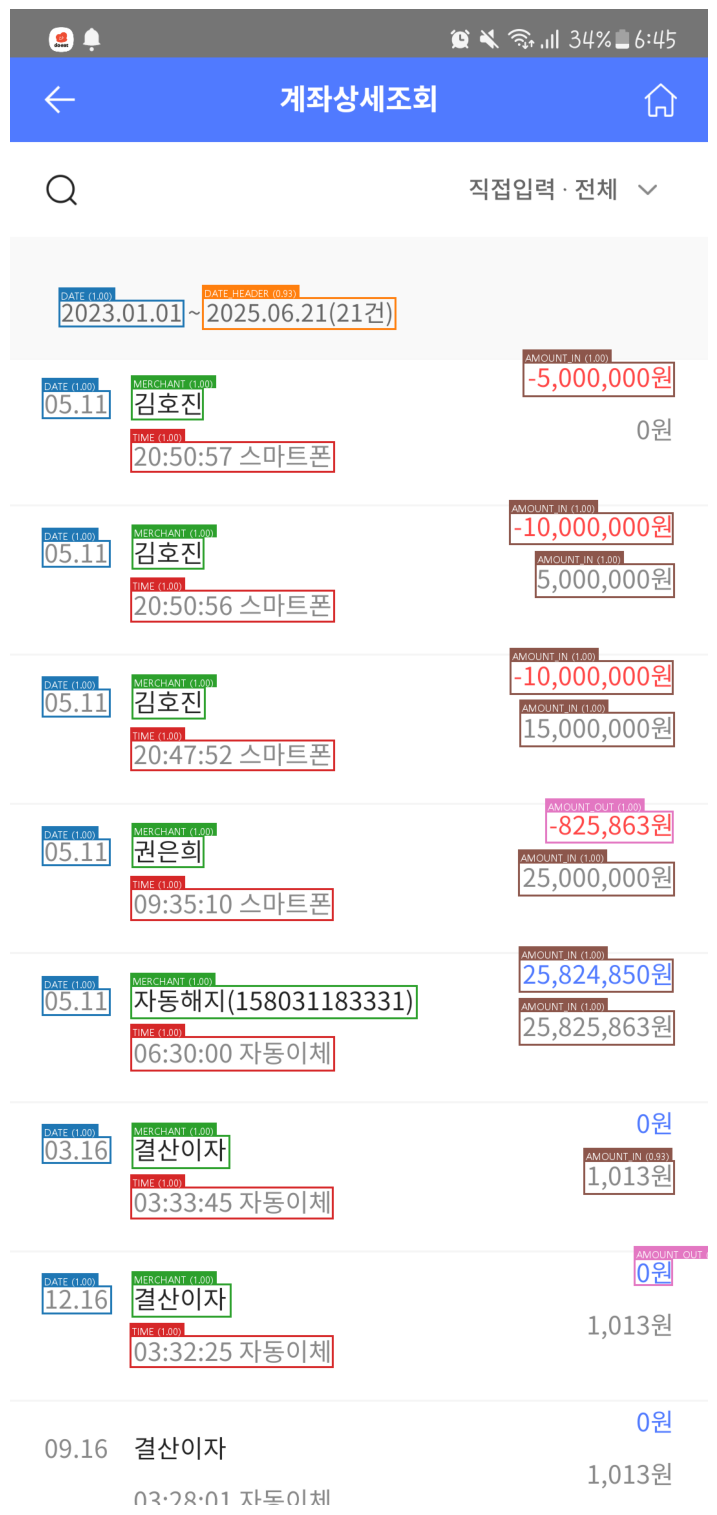


[텍스트 요약]
- DATE: 2023.01.01, 05.11, 05.11, 05.11, 05.11, 05.11, 03.16, 12.16
- DATE_HEADER: 2025.06.21(21건)
- AMOUNT_IN: 5,000,000원, 10,000,000원, 5,000,000원, 10,000,000원, 15,000,000원, 25,000,000원, 25,824,850원, 25,825,863원, 1,013원
- MERCHANT: 김호진, 김호진, 김호진, 권은희, 자동해지(158031183331), 결산이자, 결산이자
- TIME: 20:50:57 스마트폰, 20:50:56 스마트폰, 20:47:52 스마트폰, 09:35:10 스마트폰, 06:30:00 자동이체, 03:33:45 자동이체, 03:32:25 자동이체
- AMOUNT_OUT: -825,863원, 0원
--------------------------------------------------

처리 시작: toss1.png

'toss1.png'에서 텍스트를 추출합니다...

--- [toss1.png] 정보 추출 결과 ---


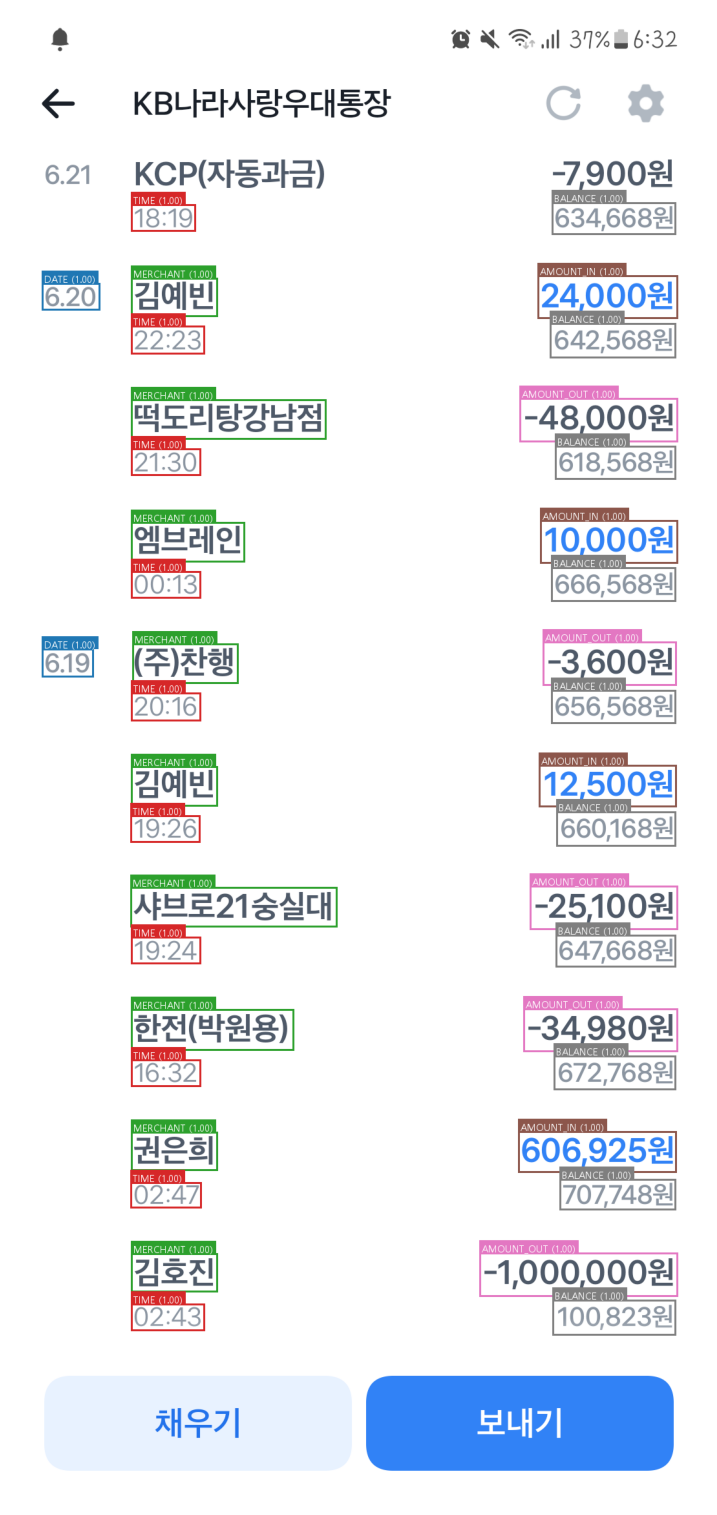


[텍스트 요약]
- TIME: 18:19, 22:23, 21:30, 00:13, 20:16, 19:26, 19:24, 16:32, 02:47, 02:43
- BALANCE: 634,668원, 642,568원, 618,568원, 666,568원, 656,568원, 660,168원, 647,668원, 672,768원, 707,748원, 100,823원
- DATE: 6.20, 6.19
- MERCHANT: 김예빈, 떡도리탕강남점, 엠브레인, (주)찬행, 김예빈, 샤브로21숭실대, 한전(박원용), 권은희, 김호진
- AMOUNT_IN: 24,000원, 10,000원, 12,500원, 606,925원
- AMOUNT_OUT: -48,000원, -3,600원, -25,100원, -34,980원, -1,000,000원
--------------------------------------------------

처리 시작: toss2.png

'toss2.png'에서 텍스트를 추출합니다...

--- [toss2.png] 정보 추출 결과 ---


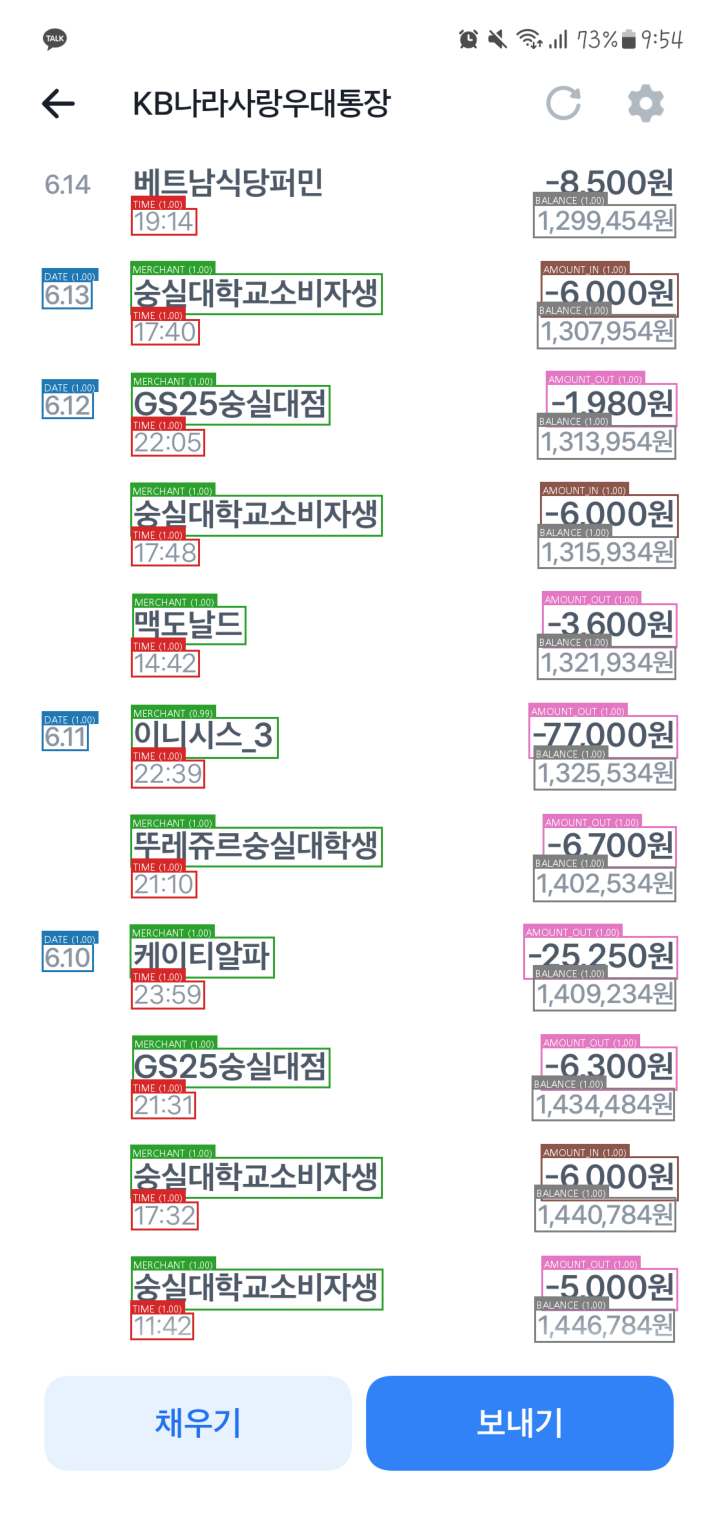


[텍스트 요약]
- TIME: 19:14, 17:40, 22:05, 17:48, 14:42, 22:39, 21:10, 23:59, 21:31, 17:32, 11:42
- BALANCE: 1,299,454원, 1,307,954원, 1,313,954원, 1,315,934원, 1,321,934원, 1,325,534원, 1,402,534원, 1,409,234원, 1,434,484원, 1,440,784원, 1,446,784원
- DATE: 6.13, 6.12, 6.11, 6.10
- MERCHANT: 숭실대학교소비자생, GS25숭실대점, 숭실대학교소비자생, 맥도날드, 3, 뚜레쥬르숭실대학생, 케이티알파, GS25숭실대점, 숭실대학교소비자생, 숭실대학교소비자생
- AMOUNT_IN: 6,000원, 6,000원, 6,000원
- AMOUNT_OUT: -1,980원, -3,600원, -77,000원, -6,700원, -25,250원, -6,300원, -5,000원
--------------------------------------------------

처리 시작: toss3.png

'toss3.png'에서 텍스트를 추출합니다...

--- [toss3.png] 정보 추출 결과 ---


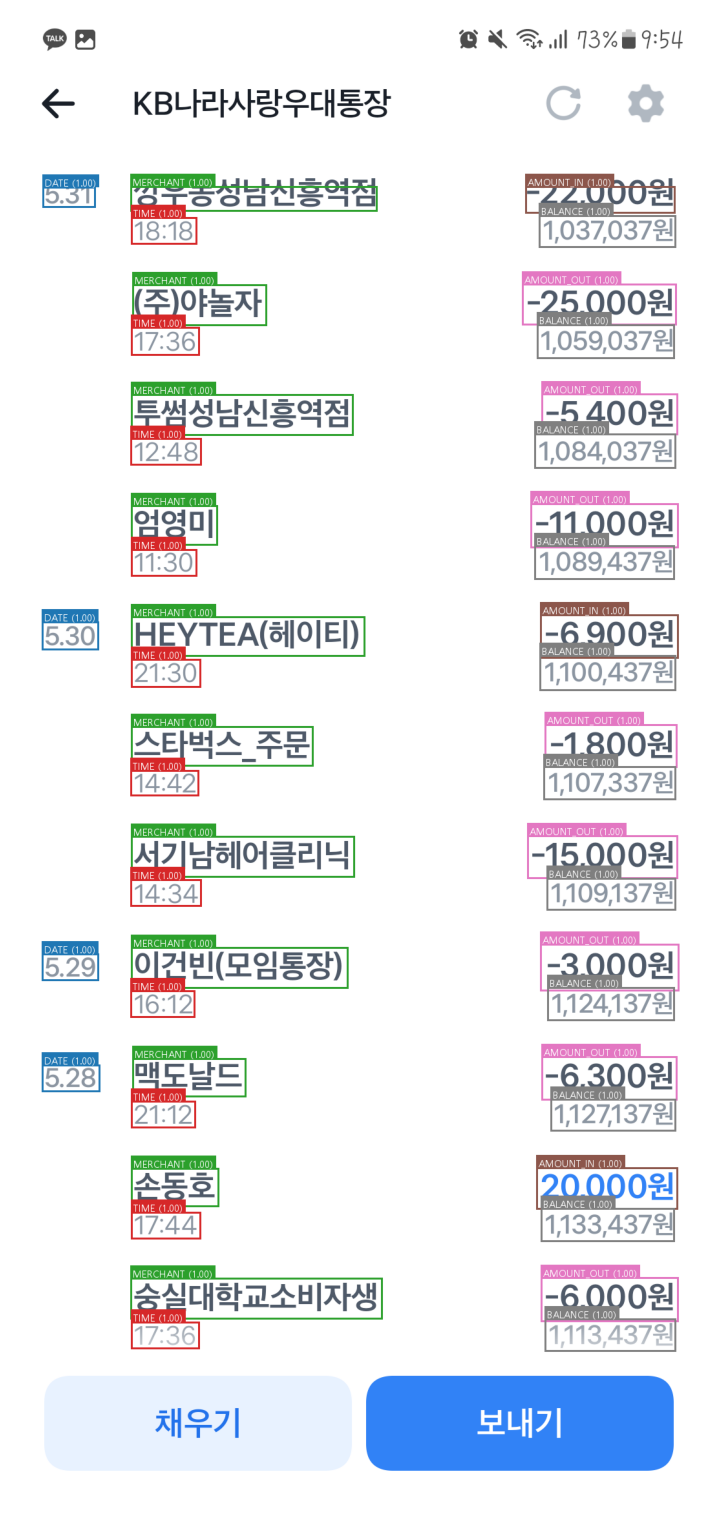


[텍스트 요약]
- DATE: 5.31, 5.30, 5.29, 5.28
- MERCHANT: @T8odL등4점, (주)야놀자, 투썸성남신흥역점, 엄영미, HEYTEA(헤이티), 주문, 서기남헤어클리닉, 이건빈(모임통장), 맥도날드, 손동호, 숭실대학교소비자생
- AMOUNT_IN: L4,0원, 6,900원, 20,000원
- TIME: 18:18, 17:36, 12:48, 11:30, 21:30, 14:42, 14:34, 16:12, 21:12, 17:44, 17:36
- BALANCE: 1,037,037원, 1,059,037원, 1,084,037원, 1,089,437원, 1,100,437원, 1,107,337원, 1,109,137원, 1,124,137원, 1,127137원, 1,133,437원, 1,113,437원
- AMOUNT_OUT: -25,000원, -5,400원, -11,000원, -1,800원, -15,000원, -3,000원, -6,300원, -6,000원
--------------------------------------------------

처리 시작: toss4.png

'toss4.png'에서 텍스트를 추출합니다...

--- [toss4.png] 정보 추출 결과 ---


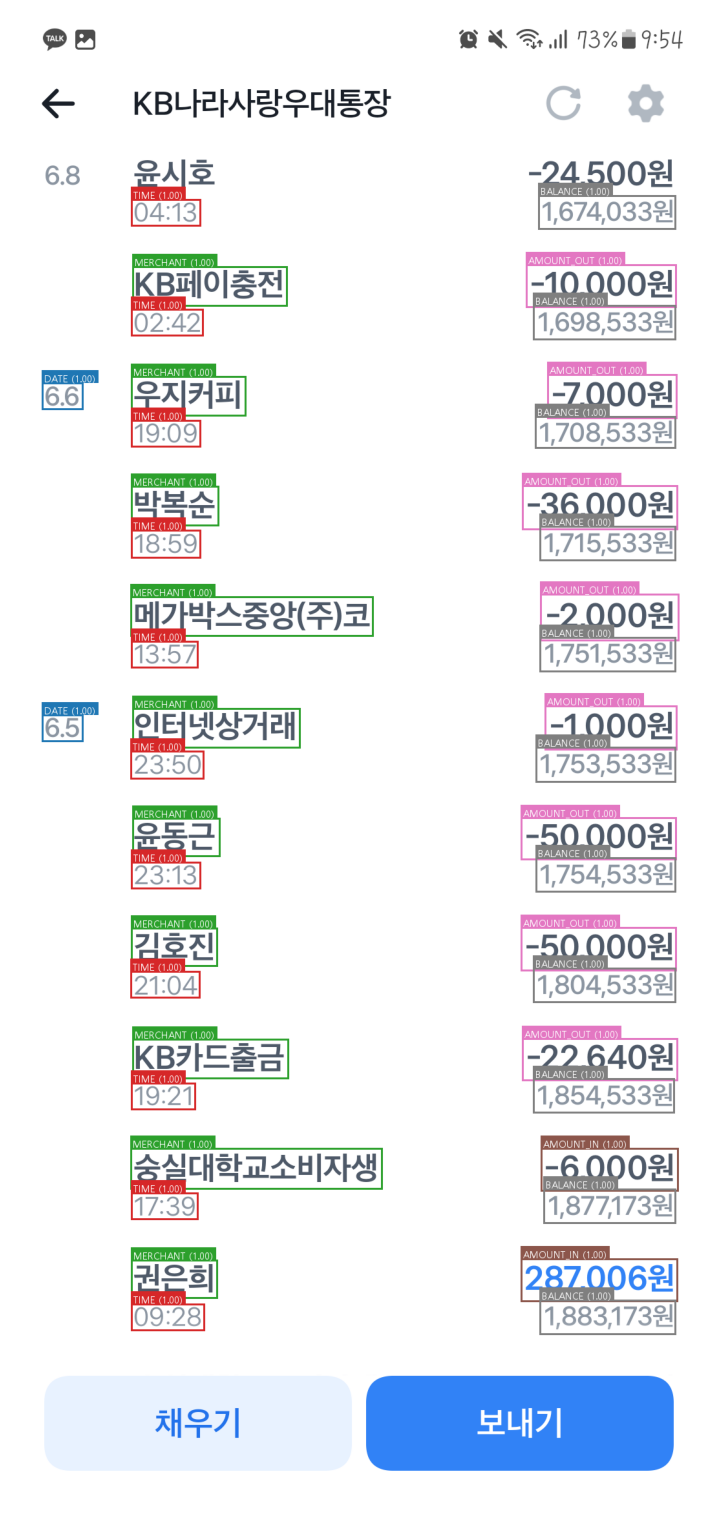


[텍스트 요약]
- TIME: 04:13, 02:42, 19:09, 18:59, 13:57, 23:50, 23:13, 21:04, 19:21, 17:39, 09:28
- BALANCE: 1,674,033원, 1,698,533원, 1,708,533원, 1,715,533원, 1,751,533원, 1,753,533원, 1,754,533원, 1,804,533원, 1,854,533원, 1,877,173원, 1,883,173원
- MERCHANT: KB페이충전, 우지커피, 박복순, 메가박스중앙(주)코, 인터넷상거래, 윤동근, 김호진, KB카드출금, 숭실대학교소비자생, 권은희
- AMOUNT_OUT: -10,000원, -7,000원, -36,000원, -2,000원, -1,000원, -50,000원, -50,000원, -22,640원
- DATE: 6.6, 6.5
- AMOUNT_IN: 6,000원, 287,006원
--------------------------------------------------

처리 시작: woori1.png

'woori1.png'에서 텍스트를 추출합니다...

--- [woori1.png] 정보 추출 결과 ---


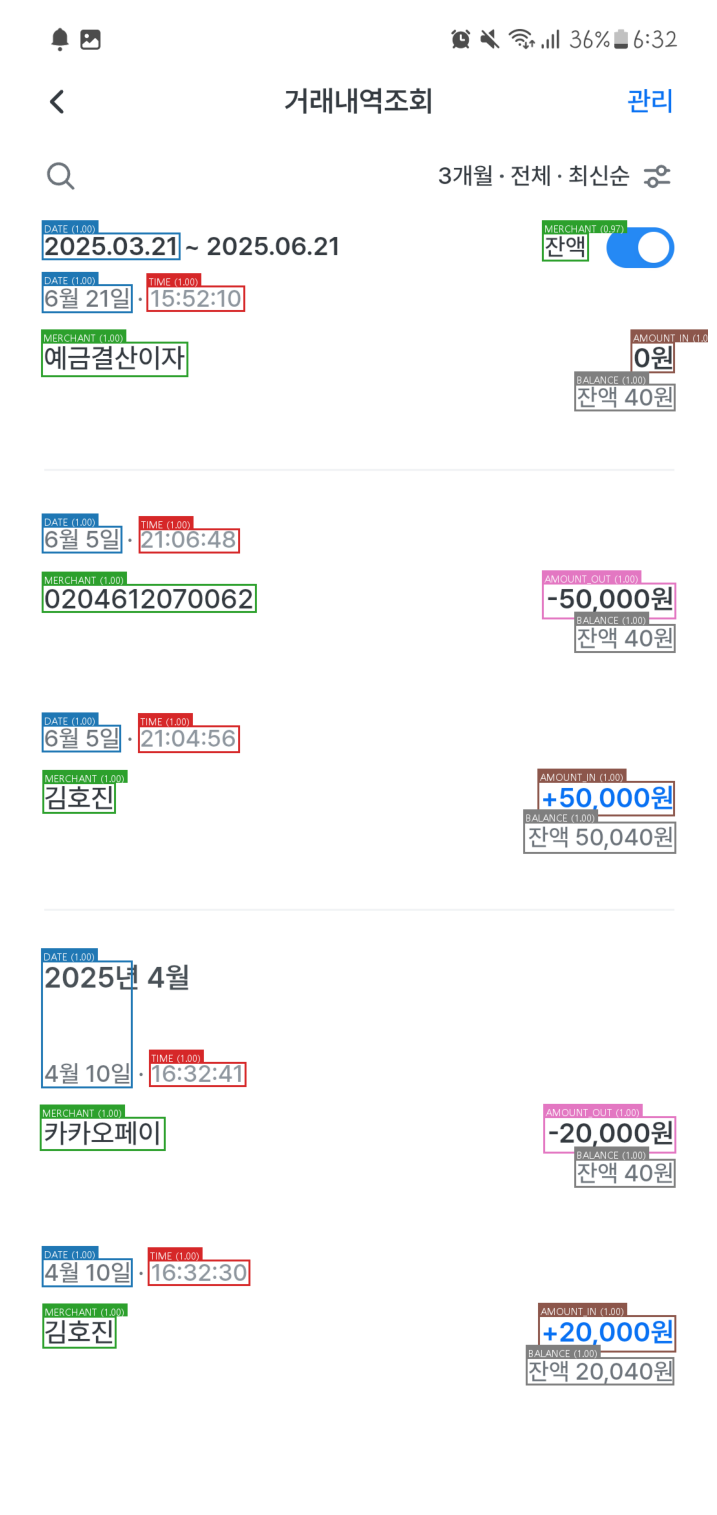


[텍스트 요약]
- DATE: 2025.03.21, 6월 21일, 6월 5일, 6월 5일, 2025년 4월 4월 10일, 4월 10일
- MERCHANT: 잔액, 예금결산이자, 0204612070062, 김호진, 카카오페이, 김호진
- TIME: 15:52:10, 21:06:48, 21:04:56, 16:32:41, 16:32:30
- AMOUNT_IN: 0원, +50,000원, +20,000원
- BALANCE: 잔액 40원, 잔액 40원, 잔액 50,040원, 잔액 40원, 잔액 20,040원
- AMOUNT_OUT: -50,000원, -20,000원
--------------------------------------------------

처리 시작: woori2.png

'woori2.png'에서 텍스트를 추출합니다...

--- [woori2.png] 정보 추출 결과 ---


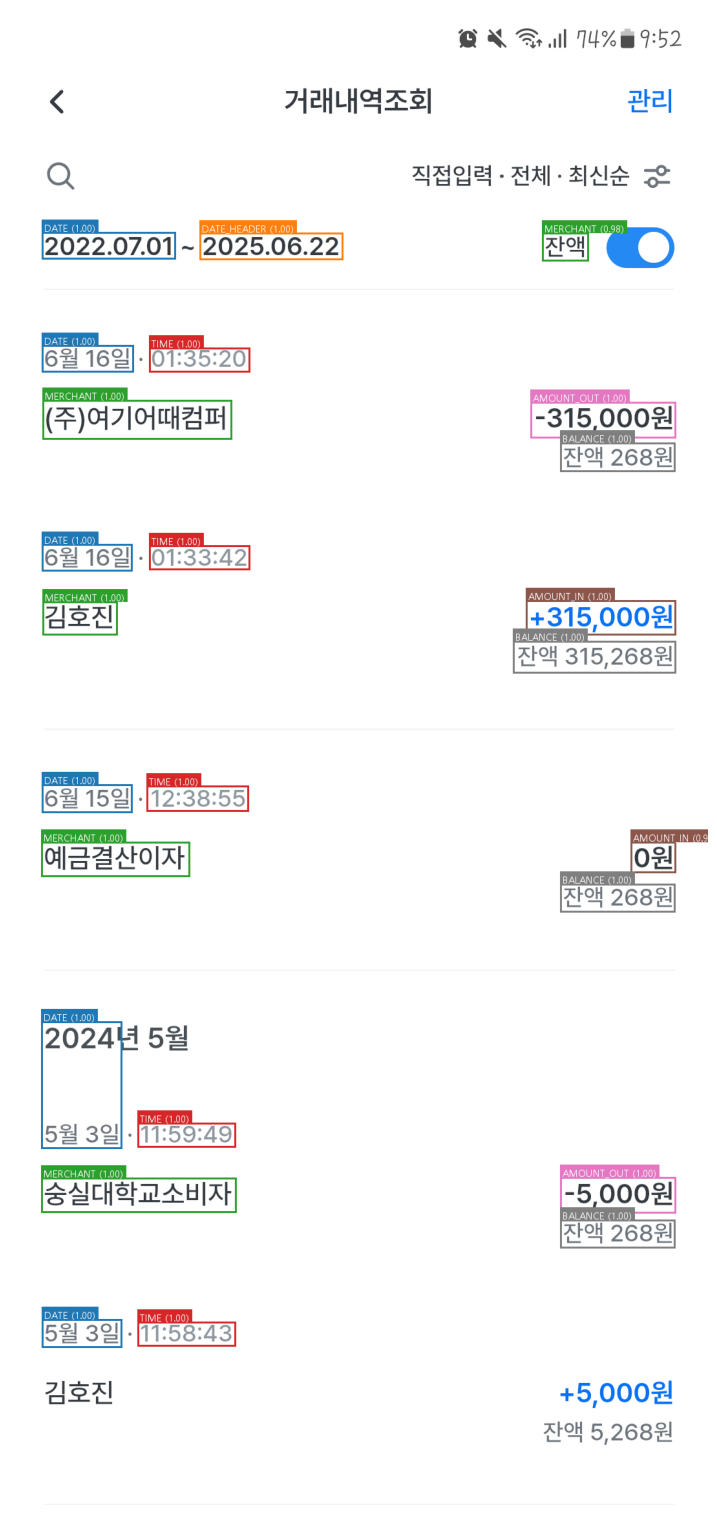


[텍스트 요약]
- DATE: 2022.07.01, 6월 16일, 6월 16일, 6월 15일, 2024년 5월 5월 3일, 5월 3일
- DATE_HEADER: 2025.06.22
- MERCHANT: 잔액, (주)여기어때컴퍼, 김호진, 예금결산이자, 숭실대학교소비자
- TIME: 01:35:20, 01:33:42, 12:38:55, 11:59:49, 11:58:43
- AMOUNT_OUT: -315,000원, -5,000원
- BALANCE: 잔액 268원, 잔액 315,268원, 잔액 268원, 잔액 268원
- AMOUNT_IN: +315,000원, 0원
--------------------------------------------------

처리 시작: woori3.png

'woori3.png'에서 텍스트를 추출합니다...

--- [woori3.png] 정보 추출 결과 ---


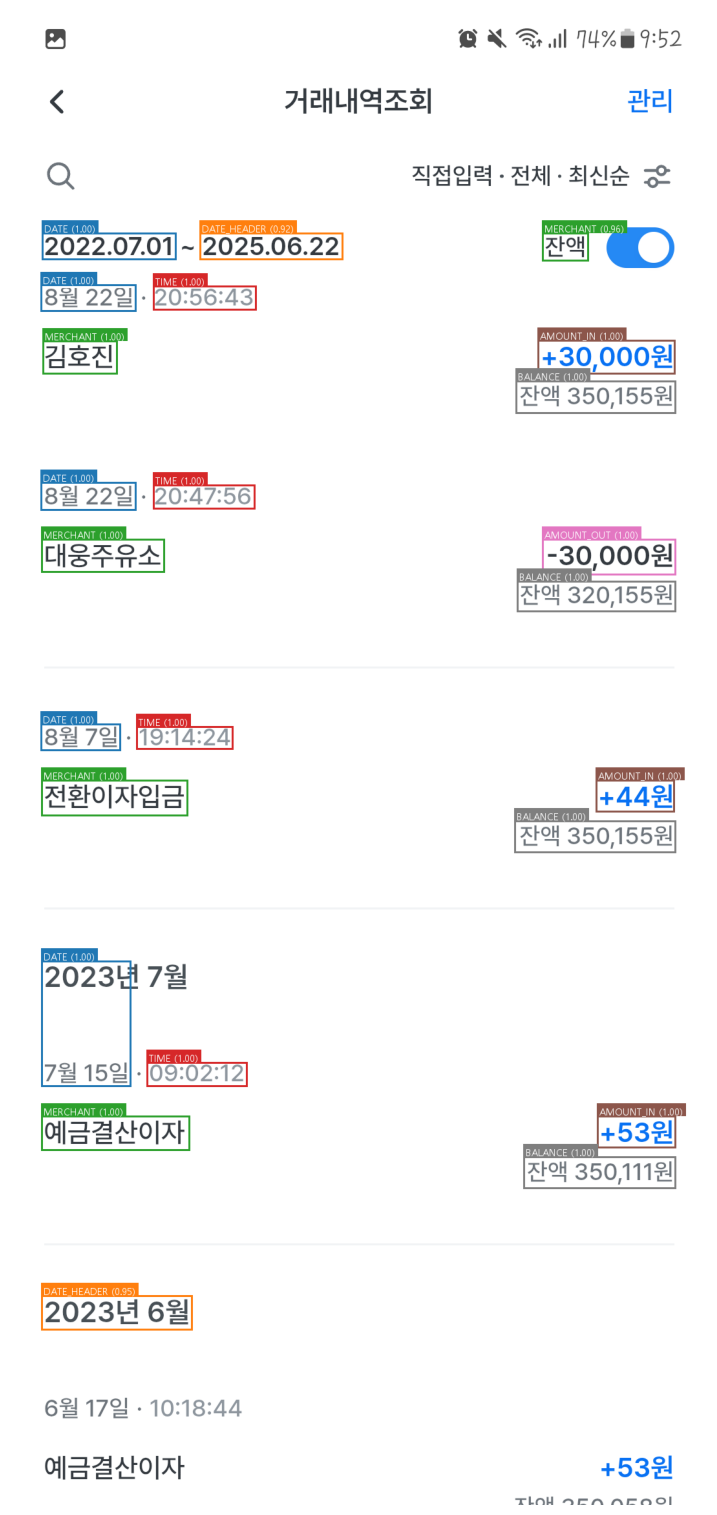


[텍스트 요약]
- DATE: 2022.07.01, 8월 22일, 8월 22일, 8월 7일, 2023년 7월 7월 15일
- DATE_HEADER: 2025.06.22, 2023년 6월
- MERCHANT: 잔액, 김호진, 대웅주유소, 전환이자입금, 예금결산이자
- TIME: 20:56:43, 20:47:56, 19:14:24, 09:02:12
- AMOUNT_IN: +30,000원, +44원, +53원
- BALANCE: 잔액 350,155원, 잔액 320,155원, 잔액 350,155원, 잔액 350,111원
- AMOUNT_OUT: -30,000원
--------------------------------------------------

처리 시작: woori4.png

'woori4.png'에서 텍스트를 추출합니다...

--- [woori4.png] 정보 추출 결과 ---


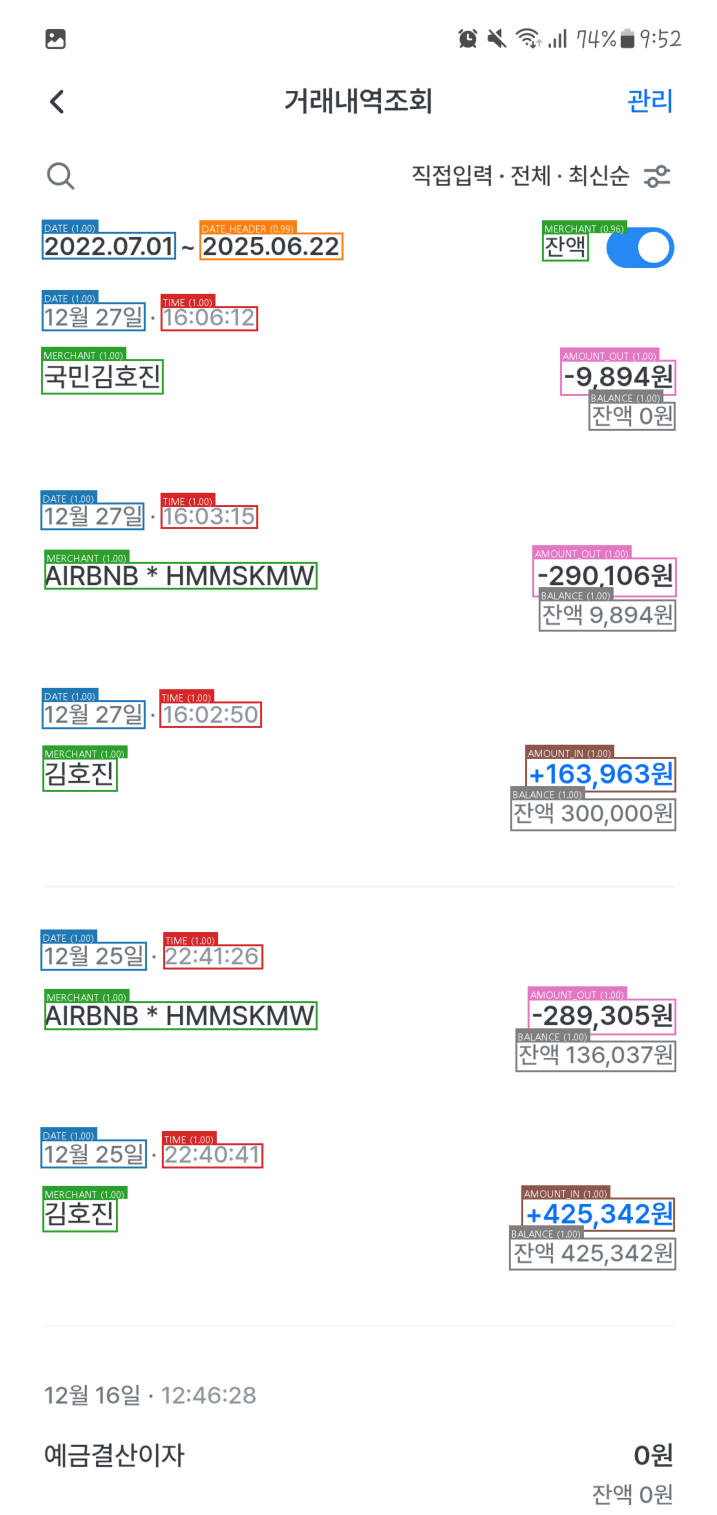


[텍스트 요약]
- DATE: 2022.07.01, 12월 27일, 12월 27일, 12월 27일, 12월 25일, 12월 25일
- DATE_HEADER: 2025.06.22
- MERCHANT: 잔액, 국민김호진, AIRBNB X HMMSKMW, 김호진, AIRBNB * HMMSKMW, 김호진
- TIME: 16:06:12, 16:03:15, 16:02:50, 22:41:26, 22:40:41
- AMOUNT_OUT: -9,894원, -290,106원, -289,305원
- BALANCE: 잔액 0원, 잔액 9,894원, 잔액 300,000원, 잔액 136,037원, 잔액 425,342원
- AMOUNT_IN: +163,963원, 4425,342원
--------------------------------------------------

처리 시작: bank_statement_long.jpg

'bank_statement_long.jpg'에서 텍스트를 추출합니다...

--- [bank_statement_long.jpg] 정보 추출 결과 ---


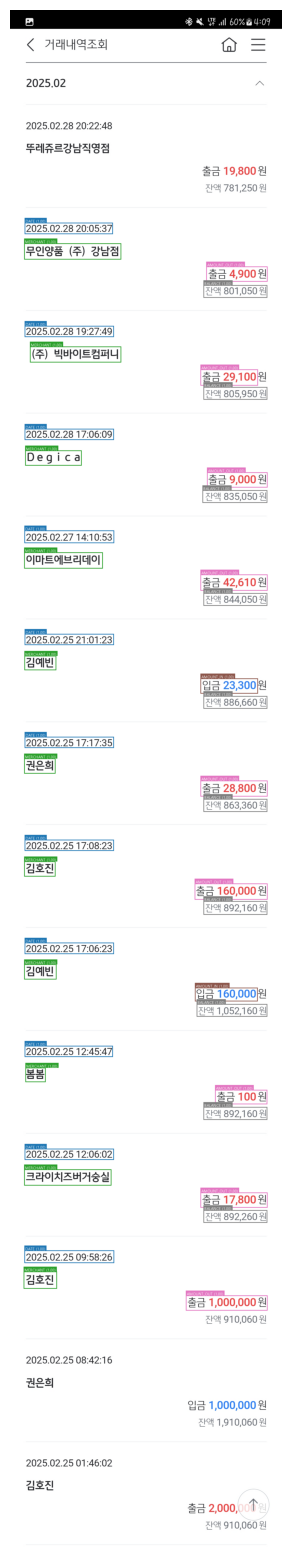


[텍스트 요약]
- DATE: 2025.02.28 20:05:37, 2025.02.28 19:27:49, 2025.02.28 17:06:09, 2025.02.27 14:10:53, 2025.02.25 21:01:23, 2025.02.25 17:17:35, 2025.02.25 17:08:23, 2025.02.25 17:06:23, 2025.02.25 12:45:47, 2025.02.25 12:06:02, 2025.02.25 09:58:26
- MERCHANT: 무인양품 (주) 강남점, (주) 빅바이트컴퍼니, Degica, 이마트에브리데이, 김예빈, 권은희, 김호진, 김예빈, 봄봄, 크라이치즈버거숭실, 김호진
- AMOUNT_OUT: 출금 4,900 원, 출금 29,100, 출금 9,000 원, 출금 42,610원, 출금 28,800원, 출금 160,000 원, 출금 100 원, 출금 17,800 원, 출금 1,000,000원
- BALANCE: 잔액 801,050 원, 잔액 805,950 원, 잔액 835,050 원, 잔액 844,050 원, 잔액 886,660 원, 잔액 863,360 원, 잔액 892,160 원, 잔액 1,052,160 원, 잔액 892,160 원, 잔액 892,260 원
- AMOUNT_IN: 입금 23,300, 입금 160,000
--------------------------------------------------

처리 시작: kabang1.jpg

'kabang1.jpg'에서 텍스트를 추출합니다...

--- [kabang1.jpg] 정보 추출 결과 ---


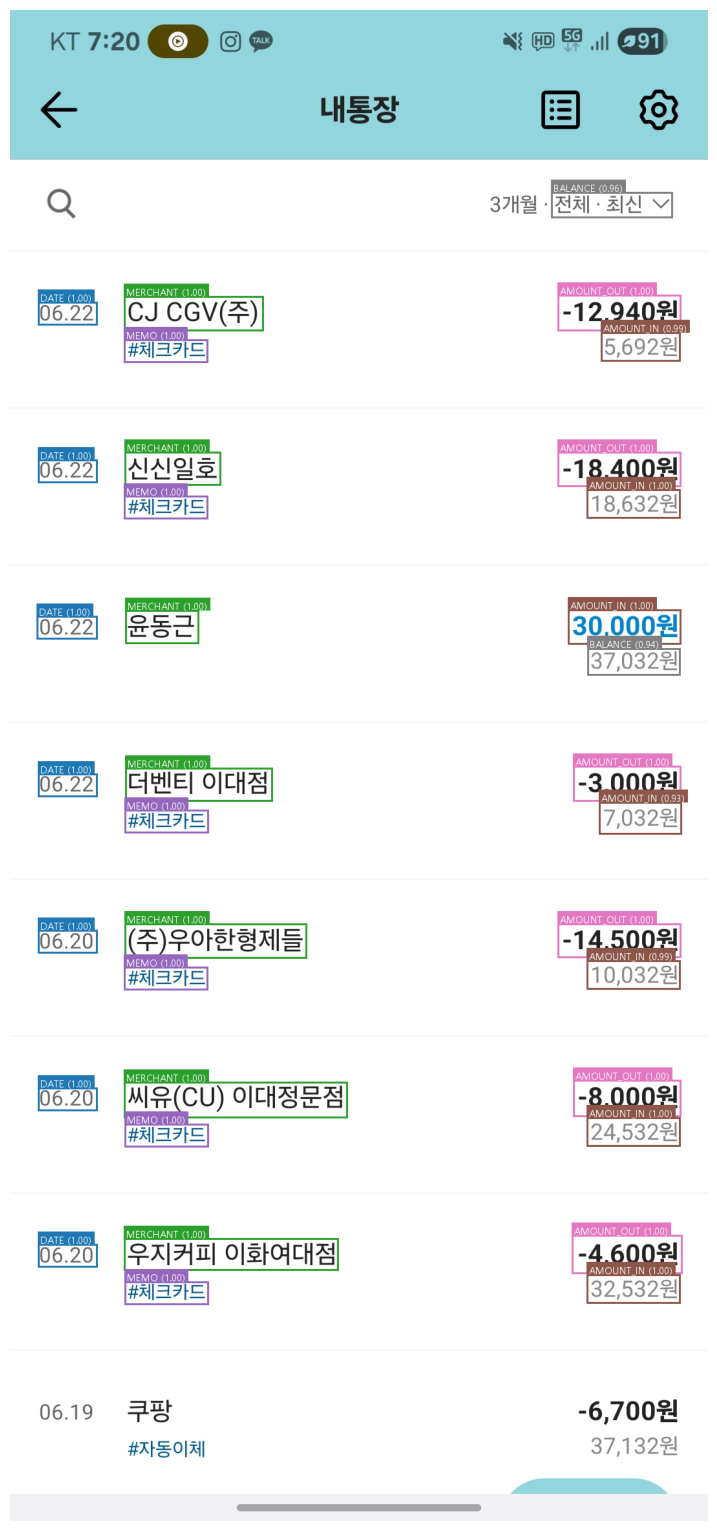


[텍스트 요약]
- BALANCE: 전체 최신, 37,032원
- DATE: 06.22, 06.22, 06.22, 06.22, 06.20, 06.20, 06.20
- MERCHANT: CJ CGV(주), 신신일호, 윤동근, 더벤티 이대점, (주)우아한형제들, 씨유(CU) 이대정문점, 우지커피 이화여대점
- AMOUNT_OUT: -12,940원, -18,400원, -3,000원, -14,500원, -8,000원, -4,600원
- MEMO: #체크카드, #체크카드, #체크카드, #체크카드, #체크카드, #체크카드
- AMOUNT_IN: 5,692원, 18,632원, 30,000원, 7,032원, 10,032원, 24,532원, 32,532원
--------------------------------------------------

처리 시작: kabang2.jpg

'kabang2.jpg'에서 텍스트를 추출합니다...

--- [kabang2.jpg] 정보 추출 결과 ---


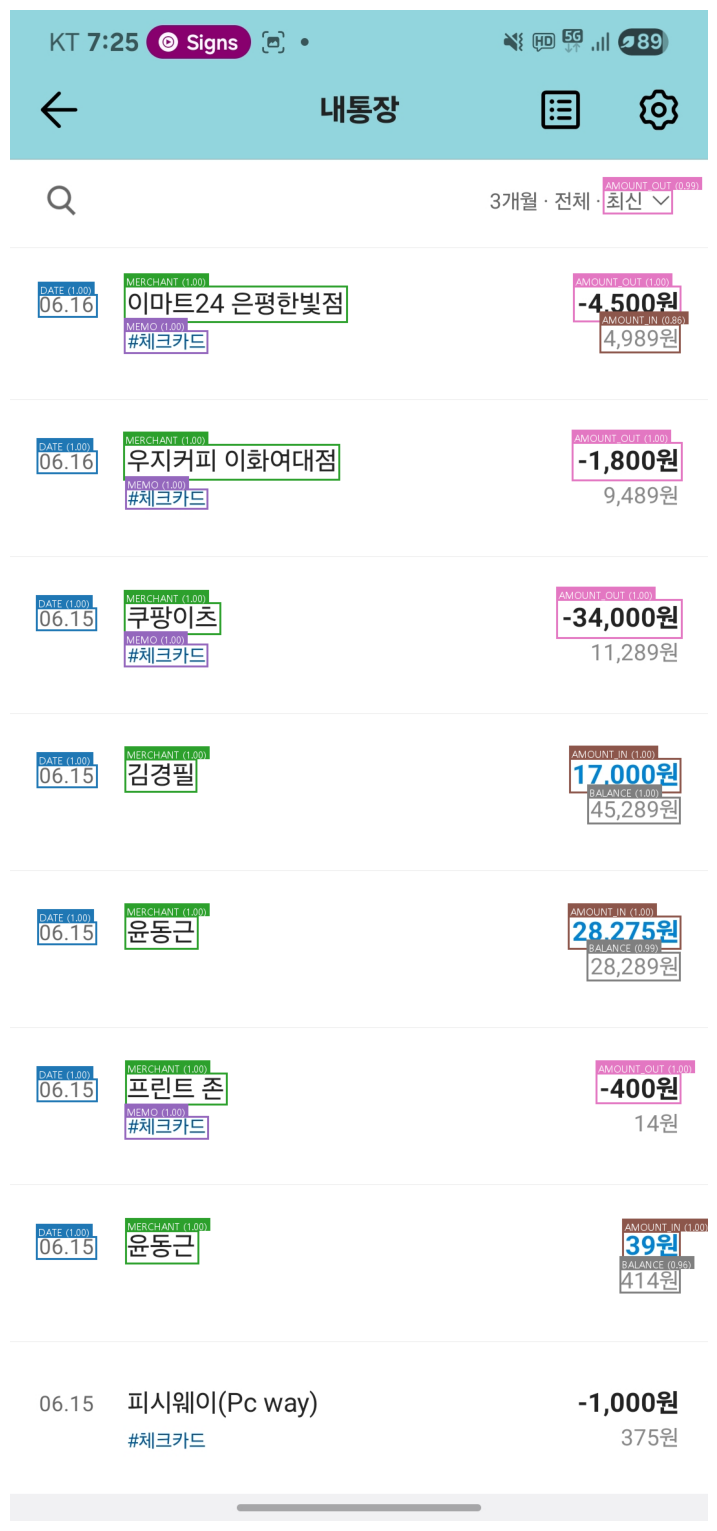


[텍스트 요약]
- AMOUNT_OUT: 최신, -4,500원, -1,800원, -34,000원, -400원
- DATE: 06.16, 06.16, 06.15, 06.15, 06.15, 06.15, 06.15
- MERCHANT: 이마트24 은평한빛점, 우지커피 이화여대점, 쿠팡이츠, 김경필, 윤동근, 프린트 존, 윤동근
- MEMO: #체크카드, #체크카드, #체크카드, #체크카드
- AMOUNT_IN: 4,989원, 17,000원, 28,275원, 39원
- BALANCE: 45,289원, 28,289원, 414원
--------------------------------------------------

처리 시작: kabang3.jpg

'kabang3.jpg'에서 텍스트를 추출합니다...

--- [kabang3.jpg] 정보 추출 결과 ---


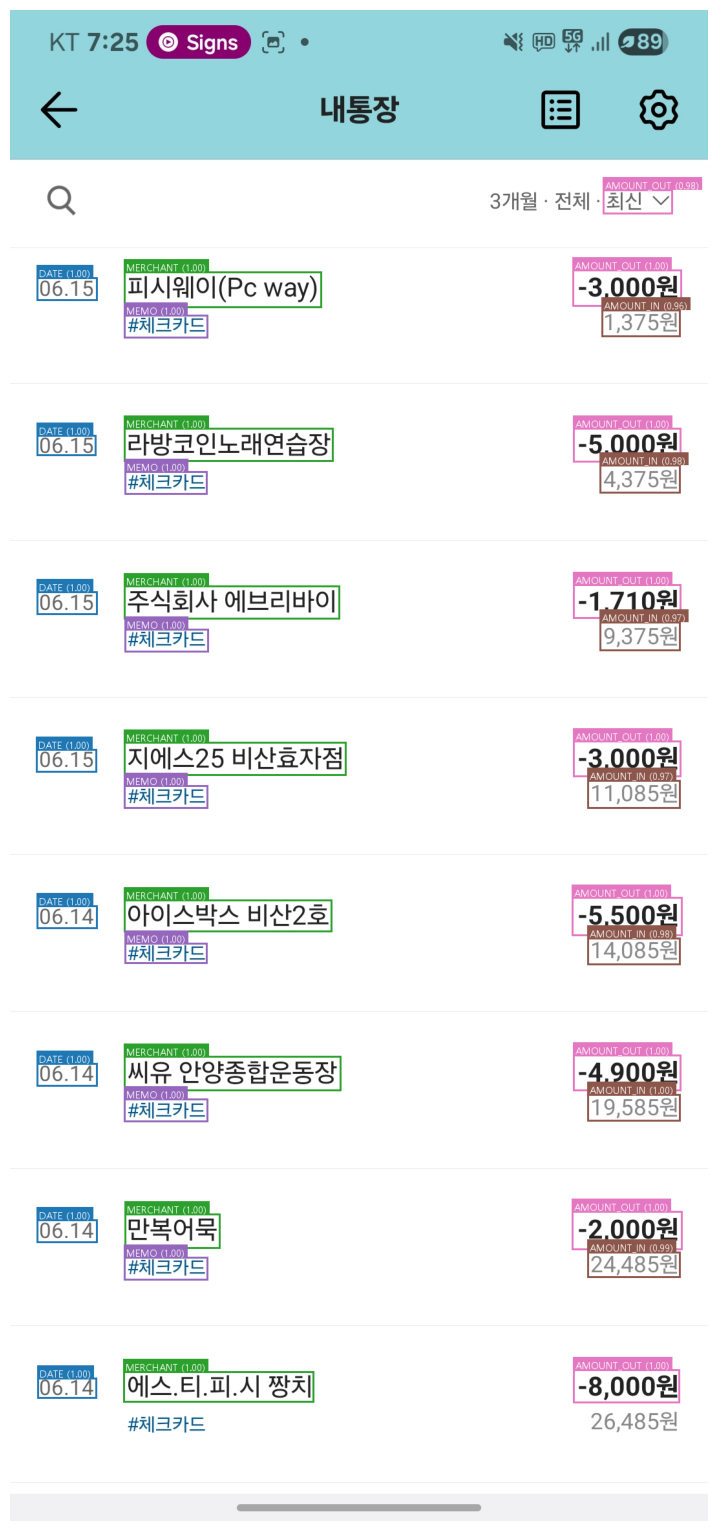


[텍스트 요약]
- AMOUNT_OUT: 최신, -3,000원, -5,000원, -1,710원, -3,000원, ~5,500원, -4,900원, -2,000원, -8,000원
- DATE: 06.15, 06.15, 06.15, 06.15, 06.14, 06.14, 06.14, 06.14
- MERCHANT: 피시웨이(Pc way), 라방코인노래연습장, 주식회사 에브리바이, 지에스25 비산효자점, 아이스박스 비산2호, 씨유 안양종합운동장, 만복어묵, 에스.티.피.시 짱치
- MEMO: #체크카드, #체크카드, #체크카드, #체크카드, #체크카드, #체크카드, #체크카드
- AMOUNT_IN: 1,375원, 4,375원, 9,375원, 11,085원, 14,085원, 19,585원, 24,485원
--------------------------------------------------

처리 시작: kabang4.jpg

'kabang4.jpg'에서 텍스트를 추출합니다...

--- [kabang4.jpg] 정보 추출 결과 ---


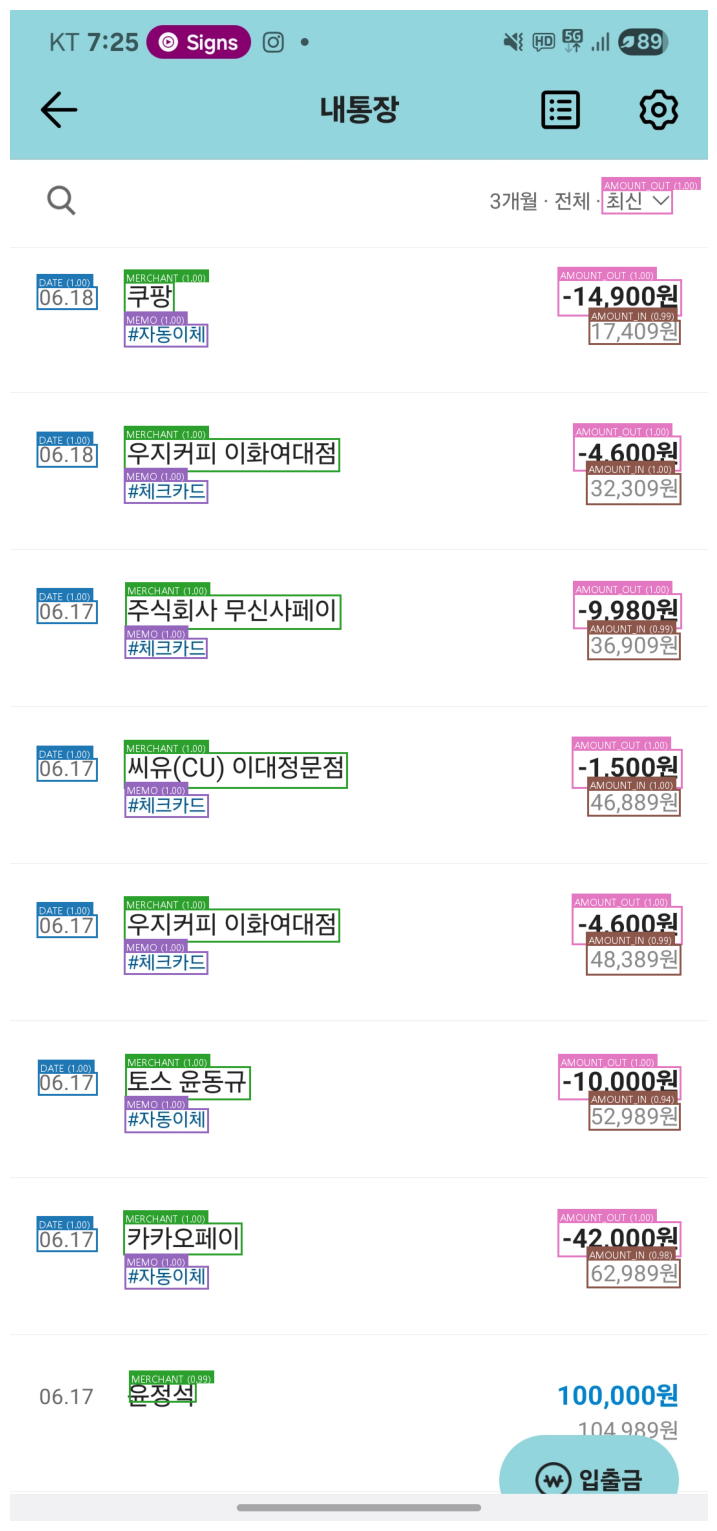


[텍스트 요약]
- AMOUNT_OUT: 최신, -14,900원, -4,600원, -9,980원, -1,500원, -4,600원, -10,000원, -42,000원
- DATE: 06.18, 06.18, 06.17, 06.17, 06.17, 06.17, 06.17
- MERCHANT: 쿠팡, 우지커피 이화여대점, 주식회사 무신사페이, 씨유(CU) 이대정문점, 우지커피 이화여대점, 토스 윤동규, 카카오페이, 유저서
- MEMO: #자동이체, #체크카드, #체크카드, #체크카드, #체크카드, #자동이체, #자동이체
- AMOUNT_IN: 17,409원, 32,309원, 36,909원, 46,889원, 48,389원, 52,989원, 62,989원
--------------------------------------------------

처리 시작: shinhan2.jpg

'shinhan2.jpg'에서 텍스트를 추출합니다...

--- [shinhan2.jpg] 정보 추출 결과 ---


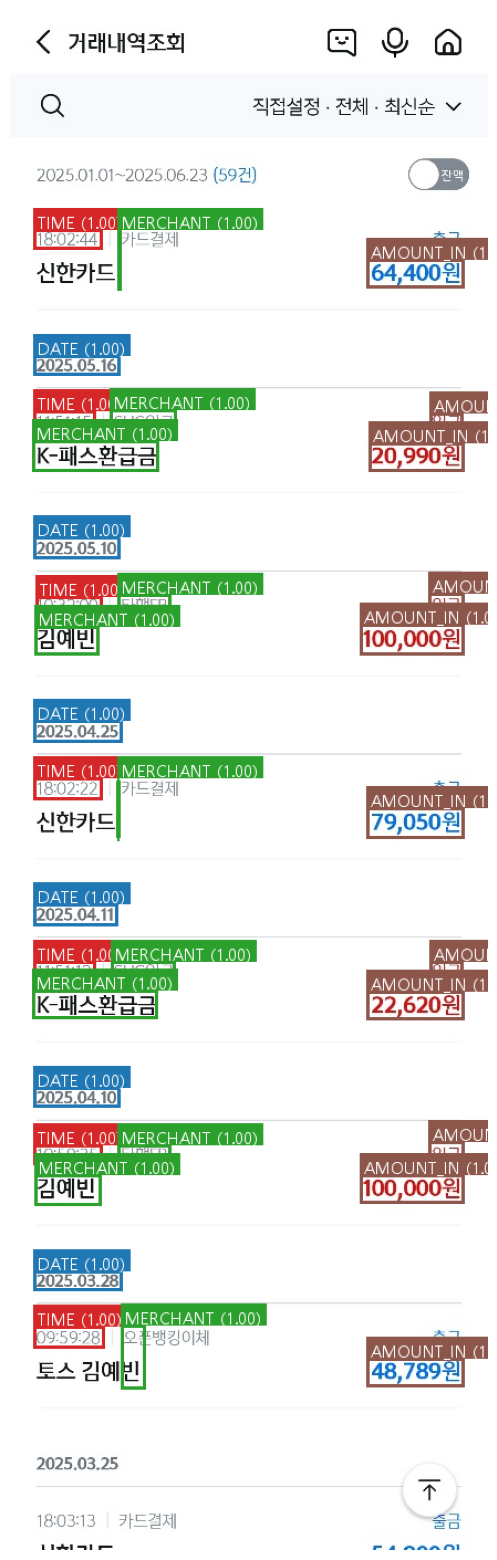


[텍스트 요약]
- TIME: 18:02:44, 11:51:15, 10:32:00, 18:02:22, 11:51:12, 10:59:35, 09:59:28
- MERCHANT: 카드결제 신한카드, SHC입금, K-패스환급금, 타행FB, 김예빈, 카드걸제 신한카드, SHC입금, K-패스환급금, 타행FB, 김예빈, 오픈뱅깅이체 토스 김예빈
- AMOUNT_IN: 64,400원, 입금, 20,990원, 입금, 100,000원, 79,050원, 입금, 22,620원, 입금, 100,000원, 48,789원
- DATE: 2025.05.16, 2025.05.10, 2025.04.25, 2025.04.11, 2025.04.10, 2025.03.28
--------------------------------------------------

처리 시작: shinhan3.jpg

'shinhan3.jpg'에서 텍스트를 추출합니다...

--- [shinhan3.jpg] 정보 추출 결과 ---


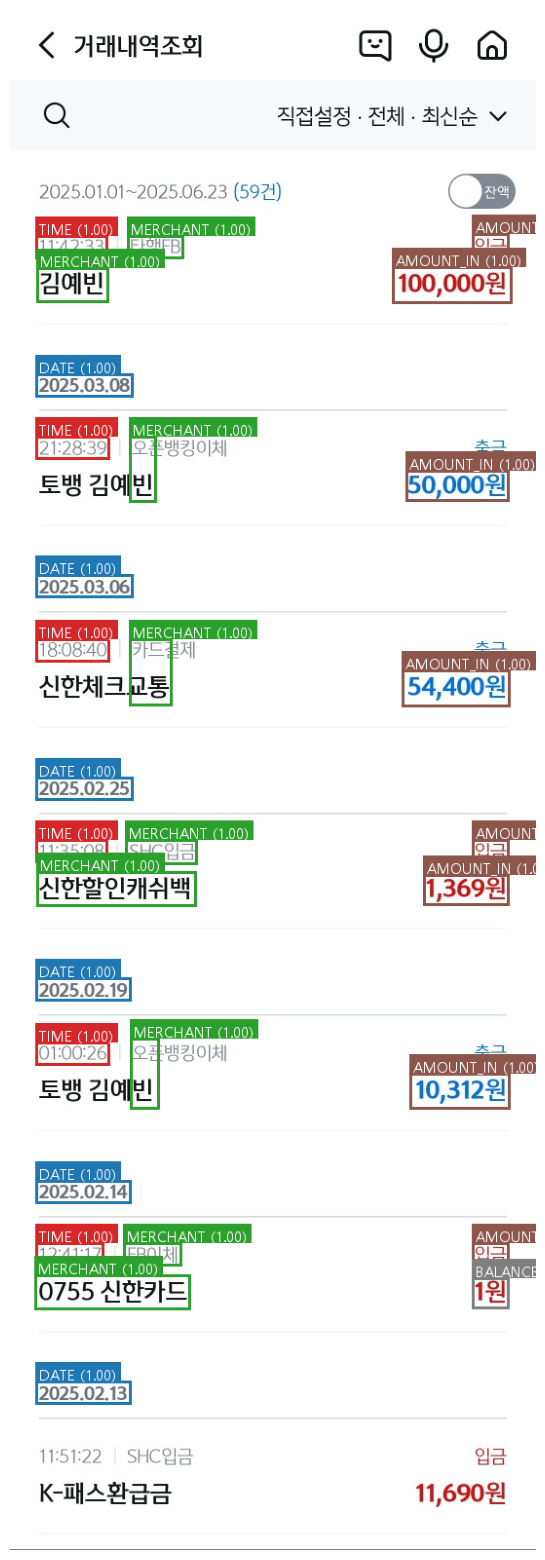


[텍스트 요약]
- TIME: 11:42:33, 21:28:39, 18:08:40, 11:35:08, 01:00:26, 12:41:17
- MERCHANT: 타행FB, 김예빈, 오픈뱅킹이체 토뱅 김예빈, 카드결제 신한체크교통, SHC입금, 신한할인캐쉬백, 오픈뱅킹이체 토뱅 김예빈, FB이체, 0755 신한카드
- AMOUNT_IN: 입금, 100,000원, 50,000원, 54,400원, 입금, 1,369원, 10,312원, 입금
- DATE: 2025.03.08, 2025.03.06, 2025.02.25, 2025.02.19, 2025.02.14, 2025.02.13
- BALANCE: 1원
--------------------------------------------------

처리 시작: shinhan4.jpg

'shinhan4.jpg'에서 텍스트를 추출합니다...

--- [shinhan4.jpg] 정보 추출 결과 ---


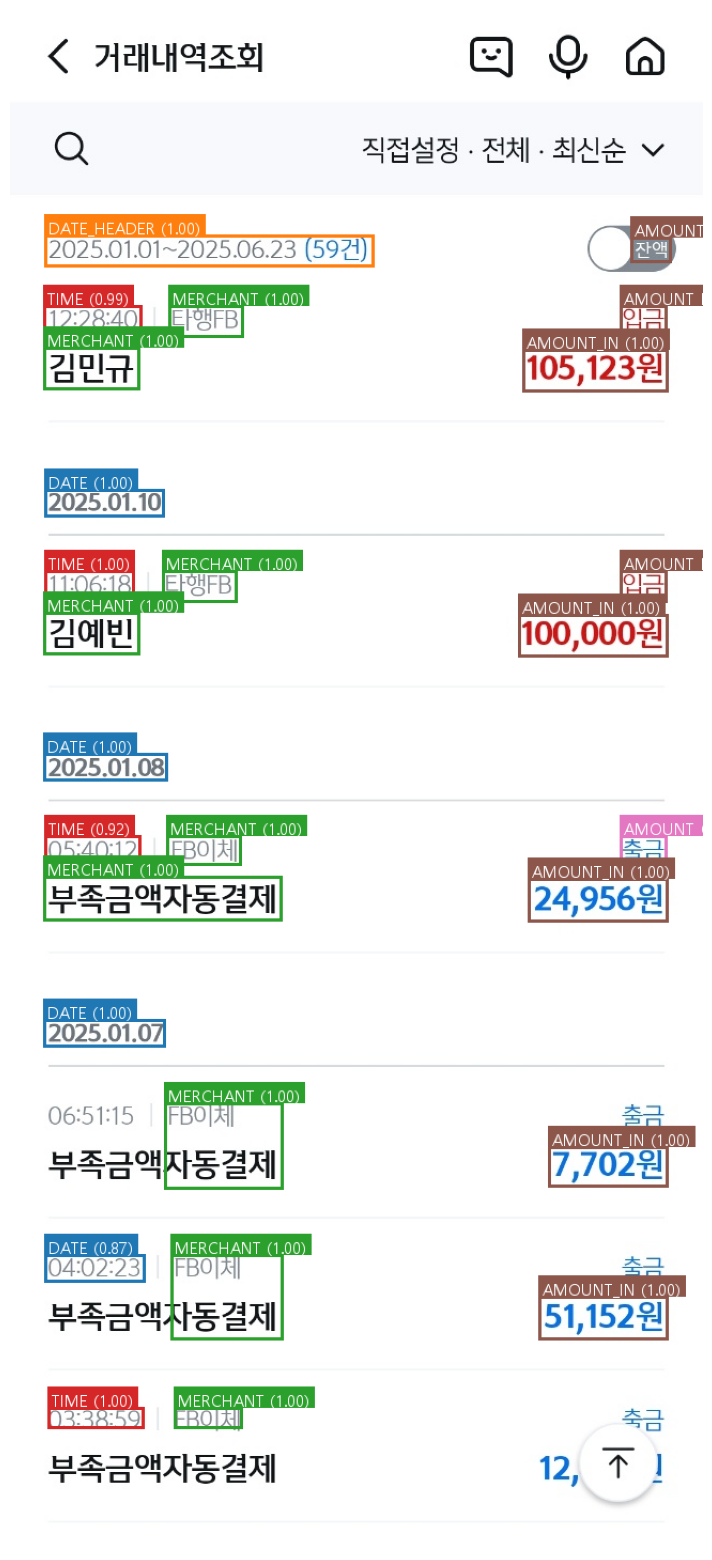


[텍스트 요약]
- DATE_HEADER: 2025.01.01~2025.06.23 (59건)
- AMOUNT_IN: 잔액, 입금, 105,123원, 입금, 100,000원, 24,956원, 7,702원, 51,152원
- TIME: 12:28:40, 11:06:18, 05:40:12, 3:38:59
- MERCHANT: 타행FB, 김민규, 타행FB, 김예빈, FB이체, 부족금액자동결제, FB이체 부족금액자동결제, FB이체 부족금액자동결제, FRO1체
- DATE: 2025.01.10, 2025.01.08, 2025.01.07, 04:02:23
- AMOUNT_OUT: 출금
--------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
# --- 1. 설정 ---
# 테스트할 이미지가 있는 폴더
TEST_IMAGE_DIR = '../bank_statement_test'
TEST_IMAGE_DIR2 = '../bank_statement'
# 사용할 폰트 경로 (None으로 두면 시스템 기본 폰트 또는 'malgun.ttf' 시도)
FONT_PATH = None 

# --- 2. 예측기 초기화 ---
try:
    predictor = DocumentPredictor(model_path=OUTPUT_DIR)
except Exception as e:
    print(f"예측기 초기화 실패: {e}")
    # Stop execution if predictor fails
    raise

# --- 3. 이미지 예측 및 결과 출력 ---
test_image_files = glob.glob(os.path.join(TEST_IMAGE_DIR, '*.png')) + \
                   glob.glob(os.path.join(TEST_IMAGE_DIR, '*.jpg')) + \
                    glob.glob(os.path.join(TEST_IMAGE_DIR2, '*.png')) + \
                    glob.glob(os.path.join(TEST_IMAGE_DIR2, '*.jpg'))

if not test_image_files:
    print(f"오류: '{TEST_IMAGE_DIR}' 폴더에서 테스트 이미지를 찾을 수 없습니다.")
else:
    for image_path in test_image_files:
        try:
            print(f"\n{'='*25}\n처리 시작: {os.path.basename(image_path)}\n{'='*25}")

            # 예측 수행
            predictions, image = predictor.predict(image_path)
            
            # 결과 시각화
            result_image = draw_predictions(image.copy(), predictions, font_path=FONT_PATH)
            
            # 결과 출력 (이미지 및 텍스트)
            print(f"\n--- [{os.path.basename(image_path)}] 정보 추출 결과 ---")
            plt.figure(figsize=(9, 20))
            plt.imshow(result_image)
            plt.axis('off')  # 축 제거
            plt.show() 
            
            print("\n[텍스트 요약]")
            if predictions:
                # 보기 좋게 라벨별로 묶어서 출력
                summary = {}
                for p in predictions:
                    label = p['label']
                    if label not in summary:
                        summary[label] = []
                    summary[label].append(p['text'])
                
                for label, texts in summary.items():
                    print(f"- {label}: {', '.join(texts)}")
            else:
                print("추출된 정보가 없습니다.")
            print("-" * 50)
        
        except Exception as e:
            print(f"\n!!!!!! 오류 발생 !!!!!!")
            print(f"'{os.path.basename(image_path)}' 처리 중 예외가 발생했습니다: {e}")
            print("다음 이미지로 넘어갑니다.")
            print("-" * 50)
            continue